# **Electricity Demand and Price Forecasting Project**


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
# Import Google Drive to access files stored in Google Drive account
from google.colab import drive

In [ ]:
# Mount Google Drive to access the files
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Import datasets

In [ ]:
# Load weather dataset from Google Drive
weather_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/weather_features.xlsx')

# Load energy dataset from Google Drive
energy_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/energy_dataset.xlsx')

# Step 2: Inspect datasets

In [ ]:
# Display the first few rows of the energy dataset
energy_df.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                        17                                NaN   
1                        16                                NaN   
2                         8                                NaN   
3                         2                                NaN   
4                         9                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                             6436                26118            25385.0   
1                             5856                24934            24382.0   
2                             5454                23515            22734.0   
3                             5151                22642            21286.0   
4                             4861                21785            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [ ]:
# Display the first few rows of the weather dataset
weather_df.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [ ]:
# Display the shape of the energy DataFrame
print("Shape of energy_df:", energy_df.shape)

# Display the shape of the weather DataFrame
print("Shape of weather_df:", weather_df.shape)

Shape of energy_df: (35064, 29)
Shape of weather_df: (178396, 17)


# Step 3: Prepare weather data (EDA: Exploratary Data Analysis)

In [ ]:
# Drop the 'city_name' column from the weather dataset as it is no longer needed
weather_df =  weather_df.drop(columns=['city_name'])

# Step 4: Aggregate weather data

In [ ]:
# Group the weather data by 'dt_iso' and aggregate using mean for numerical columns
# and mode for categorical columns

# Ensuring categorical columns are treated as strings to avoid sorting issues

weather_df['weather_id'] = weather_df['weather_id'].astype(str)
weather_df['weather_main'] = weather_df['weather_main'].astype(str)
weather_df['weather_description'] = weather_df['weather_description'].astype(str)
weather_df['weather_icon'] = weather_df['weather_icon'].astype(str)

aggregated_df = weather_df.groupby('dt_iso').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'wind_deg': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'snow_3h': 'mean',
    'clouds_all': 'mean',
    'weather_id': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_main': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_description': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_icon': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
}).reset_index()


In [ ]:
# Displaying the first few rows of the aggregated DataFrame
aggregated_df.head()

dt_iso        temp    temp_min    temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  272.491463  272.491463  272.491463    1016.4   
1  2015-01-01 01:00:00+01:00  272.512700  272.512700  272.512700    1016.2   
2  2015-01-01 02:00:00+01:00  272.099137  272.099137  272.099137    1016.8   
3  2015-01-01 03:00:00+01:00  272.089469  272.089469  272.089469    1016.6   
4  2015-01-01 04:00:00+01:00  272.145900  272.145900  272.145900    1016.6   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0      82.4         2.0     135.2      0.0      0.0      0.0         0.0   
1      82.4         2.0     135.8      0.0      0.0      0.0         0.0   
2      82.0         2.4     119.0      0.0      0.0      0.0         0.0   
3      82.0         2.4     119.2      0.0      0.0      0.0         0.0   
4      82.0         2.4     118.4      0.0      0.0      0.0         0.0   

  weather_id weather_main weather_description weather_icon  
0        800        clear        sky is clear          01n  
1        800        clear        sky is clear          01n  
2        800        clear        sky is clear          01n  
3        800        clear        sky is clear          01n  
4        800        clear        sky is clear          01n

In [ ]:
# Convert 'dt_iso' column to datetime with UTC timezone
aggregated_df['dt_iso'] = pd.to_datetime(aggregated_df['dt_iso'], utc=True)

# Convert 'time' column to datetime with UTC timezone
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)

# Step 5: Merge datasets as a Left Join based on datetime columns

In [ ]:
merged_df = pd.merge(energy_df, aggregated_df, left_on='time', right_on='dt_iso')

In [ ]:
# Drop the 'dt_iso' column from merged_df
merged_df = merged_df.drop(columns=['dt_iso'])

In [ ]:
# Display the shape (dimensions) of merged_df
merged_df.shape

(35064, 44)

In [ ]:
# Sum numerical columns in merged_df
merged_df.select_dtypes(include=['number']).sum()

generation biomass                             1.344023e+07
generation fossil brown coal/lignite           1.570268e+07
generation fossil coal-derived gas             0.000000e+00
generation fossil gas                          1.970545e+08
generation fossil hard coal                    1.491581e+08
generation fossil oil                          1.045462e+07
generation fossil oil shale                    0.000000e+00
generation fossil peat                         0.000000e+00
generation geothermal                          0.000000e+00
generation hydro pumped storage aggregated     0.000000e+00
generation hydro pumped storage consumption    1.666661e+07
generation hydro run-of-river and poundage     3.406781e+07
generation hydro water reservoir               9.129885e+07
generation marine                              0.000000e+00
generation nuclear                             2.195312e+08
generation other                               2.110771e+06
generation other renewable              

In [ ]:
# Drop columns in merged_df that are entirely null or 0-valued
merged_df = merged_df.dropna(axis=1, how='all').loc[:, (merged_df != 0).any(axis=0)]

In [ ]:
# Check for missing values in merged_df
merged_df.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil coal-derived gas             18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation fossil oil shale                    18
generation fossil peat                         18
generation geothermal                          18
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation marine                              19
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind offshore                       18


In [ ]:
# Forward fill missing values in merged_df
merged_df.ffill(inplace=True)

# Backward fill remaining missing values in merged_df
merged_df.bfill(inplace=True)

# Check for any remaining missing values in merged_df
merged_df.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil coal-derived gas             0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation fossil oil shale                    0
generation fossil peat                         0
generation geothermal                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation marine                              0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offshore                       0
generation wind onsh

In [ ]:
# Displaying the first 5 rows of merged_df
merged_df.head(5)

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0  ...         2.0     135.2      0.0      0.0      0.0         0.0   
1  ...         2.0     135.8      0.0      0.0      0.0         0.0   
2  ...         2.4     119.0      0.0      0.0      0.0         0.0   
3  ...         2.4     119.2      0.0      0.0      0.0         0.0   
4  ...         2.4     118.4      0.0      0.0      0.0         0.0   

   weather_id  weather_main  weather_description  weather_icon  
0         800         clear         sky is clear           01n  
1         800         clear         sky is clear           01n  
2         800         clear         sky is clear           01n  
3         800         clear         sky is clear           01n  
4         800         clear         sky is clear           01n  

[5 rows x 42 columns]

In [ ]:
# Drop empty columns in merged dataset
columns_to_drop = ['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation marine', 'generation wind offshore']
merged_df = merged_df.drop(columns=columns_to_drop)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  float64            
 8   generation hydro water res

In [ ]:
merged_df.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35064.000000                          35064.000000   
mean           383.532797                            448.091918   
std             85.346455                            354.616732   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35064.000000                 35064.000000   
mean             5622.705653                  4256.550622   
std              2201.557635                  1961.973297   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4969.500000                  4475.000000   
75%              6429.000000                  5839.000000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35064.000000                                 35064.000000   
mean              298.341319                                   475.563997   
std                52.518371                                   792.291849   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35064.000000   
mean                                   972.206337   
std                                    400.714694   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35064.000000        35064.000000      35064.000000   
mean                        2605.496121         6263.501854         60.225416   
std                         1835.074561          840.244555         20.238846   
min                            0.000000            0.000000          0.000000   
25%                         1078.000000         5759.000000         53.000000   
50%                         2165.000000         6564.000000         57.000000   
75%                         3757.250000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       ...      temp_min      temp_max       pressure      humidity  \
count  ...  35064.000000  35064.000000   35064.000000  35064.000000   
mean   ...    288.396642    291.147454    1070.205996     68.217013   
std    ...      7.121843      7.507959    2692.266470     14.890167   
min    ...    270.550000    271.941863     812.400000     22.600000   
25%    ...    282.950000    285.350000    1012.800000     56.800000   
50%    ...    287.750000    290.550000    1017.000000     69.800000   
75%    ...    293.610000    296.750000    1021.000000     80.200000   
max    ...    308.550000    313.548000  202469.000000    100.000000   

         wind_speed      wind_deg       rain_1h       rain_3h       snow_3h  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       2.467529    166.614552      0.073212      0.000386      0.004846   
std        1.357751     57.493555      0.202562      0.003360      0.10110

In [ ]:
# Displaying the shape (dimensions) of merged_df
merged_df.shape

(35064, 36)

Identify and treat the outliers in numerical columns of a DataFrame using Interquartile Range (IQR) Method

In [ ]:
# Function to identify outliers in numerical columns of a DataFrame
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the 'price actual' column

def identify_outliers_df(df, column):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers[column] = (df[column] < lower_bound) | (df[column] > upper_bound)
        return outliers

In [ ]:
Q1 = merged_df['price actual'].quantile(0.25)
Q3 = merged_df['price actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outlier = merged_df[(merged_df['price actual'] < lower_bound) | (merged_df['price actual'] > upper_bound)]
print(f"Number of outliers: {len(outlier)}")

Number of outliers: 699


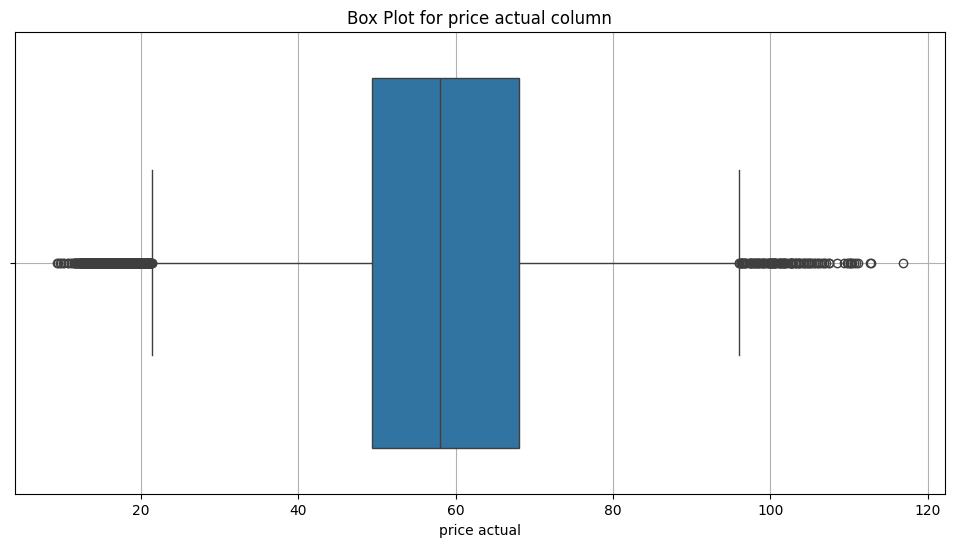

In [ ]:
# Box plot to visualize the outliers in 'price actual' column
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['price actual'])
plt.title("Box Plot for price actual column")
plt.xlabel("price actual")
plt.grid(True)
plt.show()

In [ ]:
# Remove ouliers with the help of Interpolation method

# Replace outliers with NaN
merged_df['price_actual_interpolated'] = merged_df['price actual'].apply(
    lambda x: None if x < lower_bound or x > upper_bound else x
)

merged_df['price_actual_interpolated'].isnull().sum()

699

In [ ]:
# Interpolate to replace NaN values
merged_df['price_actual_interpolated'] = merged_df['price_actual_interpolated'].interpolate()
merged_df['price_actual_interpolated'].isnull().sum()

0

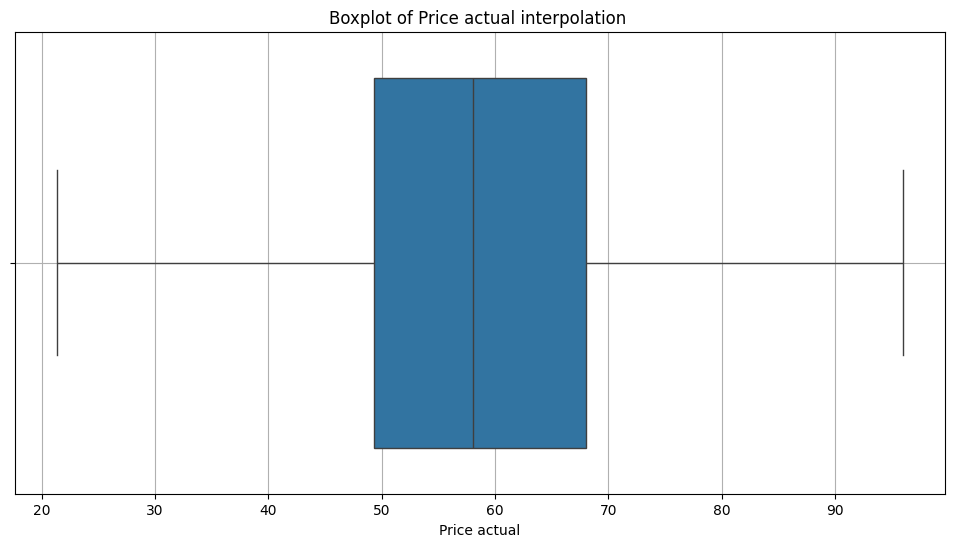

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['price_actual_interpolated'])
plt.title("Boxplot of Price actual interpolation ")
plt.xlabel("Price actual")
plt.grid(True)
plt.show()

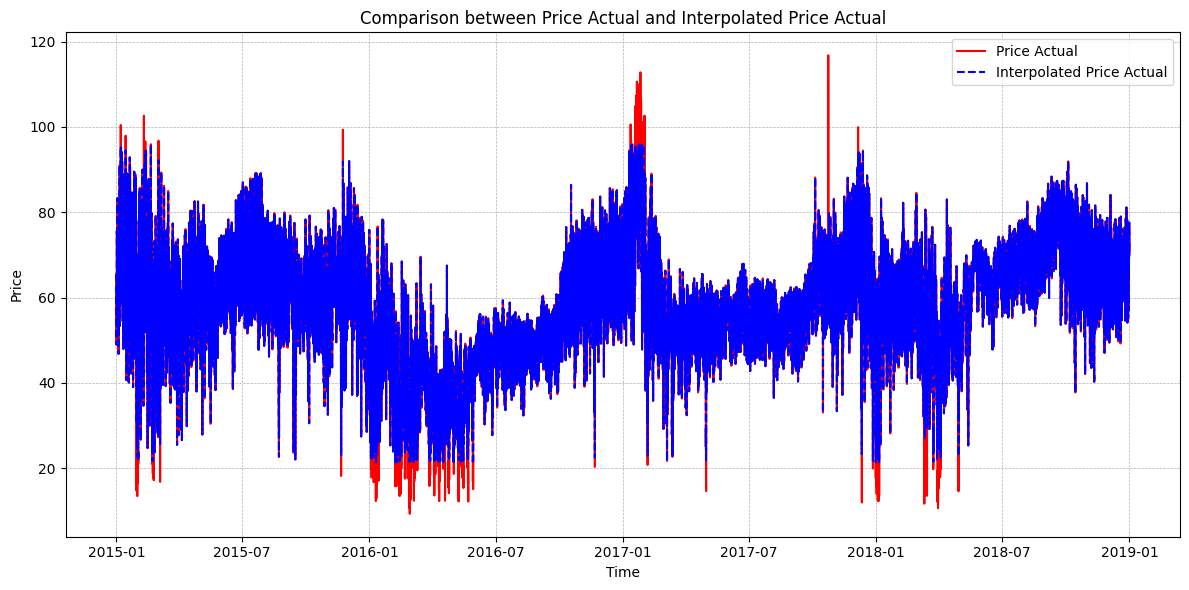

In [ ]:
# Plot for Comparison between Price Actual and Interpolated Price
plt.figure(figsize=(12,6))

# Plot Price Actual
plt.plot(merged_df['time'], merged_df['price actual'], label='Price Actual', color='red', linestyle='-')

# Plot Price Actual Interpolated
plt.plot(merged_df['time'], merged_df['price_actual_interpolated'], label='Interpolated Price Actual', color='blue', linestyle='--')

# Title and labels
plt.title('Comparison between Price Actual and Interpolated Price Actual')
plt.xlabel('Time')
plt.ylabel('Price')

# Add grid lines for better readability
plt.grid(True, linestyle='--', linewidth=0.5)

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Step 6: Feature Engginering

Create is_weekday column

In [ ]:
# Extract the day of the week (Monday=0, Sunday=6) from the 'time' column
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek

# Create a new column indicating whether the day is a weekday (1) or weekend (0)
# Monday to Friday (0 to 4) are considered weekdays, Saturday and Sunday (5 and 6) are considered weekends
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 0 if x >= 5 else 1)

Create peak/off-peak column

In [ ]:
# Extract hour from the 'time' column
merged_df['hour'] = merged_df['time'].dt.hour

# Calculate the average electricity demand for each hour across all days
hourly_avg_demand = merged_df.groupby('hour')['total load actual'].mean().reset_index()
hourly_avg_demand.columns = ['hour', 'avg_hourly_demand']

# Merge the hourly average demand back to the original dataset
merged_df = pd.merge(merged_df, hourly_avg_demand, on='hour', how='left')

# Create the 'peak/off-peak' column:
# Assign 1 if the total load actual is greater than the average hourly demand, indicating peak hours;
# Otherwise, assign 0, indicating off-peak hours.
merged_df['peak|off-peak_load'] = merged_df.apply(
    lambda row: 1 if row['total load actual'] > row['avg_hourly_demand'] else 0, axis=1
)

Create average electricity price column

In [ ]:
# Calculate the average electricity price for each hour across all days
hourly_avg_price = merged_df.groupby('hour')['price_actual_interpolated'].mean().reset_index()
hourly_avg_price.columns = ['hour', 'avg_hourly_price']

# Merge the hourly average price back to the original dataset
merged_df = pd.merge(merged_df, hourly_avg_price, on='hour', how='left')

Create a column for each month

In [ ]:
# Ensure the 'time' column is in datetime format and remove timezone information
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True).dt.tz_convert(None)

# Create new columns for each month indicating whether the data corresponds to that month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

for month_index, month in enumerate(months, start=1):
    merged_df[month] = (merged_df['time'].dt.month == month_index).astype(int)

In [ ]:
# Convert 'time' column to datetime format, specifying the format and handling errors
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Extract month, day, weekday name, and weekend indicator from 'time' column
merged_df['month'] = merged_df['time'].dt.month
merged_df['day'] = merged_df['time'].dt.day
merged_df['weekday'] = merged_df['time'].dt.day_name()
merged_df['weekend'] = merged_df['time'].dt.dayofweek >= 5  # True if Saturday or Sunday, else False

In [ ]:
merged_df.head(5)

time  generation biomass  \
0 2014-12-31 23:00:00               447.0   
1 2015-01-01 00:00:00               449.0   
2 2015-01-01 01:00:00               448.0   
3 2015-01-01 02:00:00               438.0   
4 2015-01-01 03:00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4                       3840.0                  156.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1826.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  July  August  \
0                            1899.0              7096.0  ...     0       0   
1                            1658.0              7096.0  ...     0       0   
2                            1371.0              7099.0  ...     0       0   
3                             779.0              7098.0  ...     0       0   
4                             720.0              7097.0  ...     0       0   

   September  October  November  December  month  day    weekday  weekend  
0          0        0         0         1     12   31  Wednesday    False  
1          0        0         0         0      1    1   Thursday    False  
2          0        0         0         0      1    1   Thursday    False  
3          0        0         0         0      1    1   Thursday    False  
4          0        0         0         0      1    1   Thursday    False  

[5 rows x 59 columns]

In [ ]:
# Convert 'time' column to string format for exporting
merged_df['time'] = merged_df['time'].astype(str)

output_path = '/content/drive/MyDrive/Infosys Project/merged_dataset.xlsx'

# Export merged_df to Excel file without index column
merged_df.to_excel(output_path, index=False)

In [ ]:
# merged_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/merged_dataset.xlsx')

In [ ]:
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

In [ ]:
merged_df.shape

(35064, 59)

# Step 7: Visualization

Hourly Demand and Price Analysis

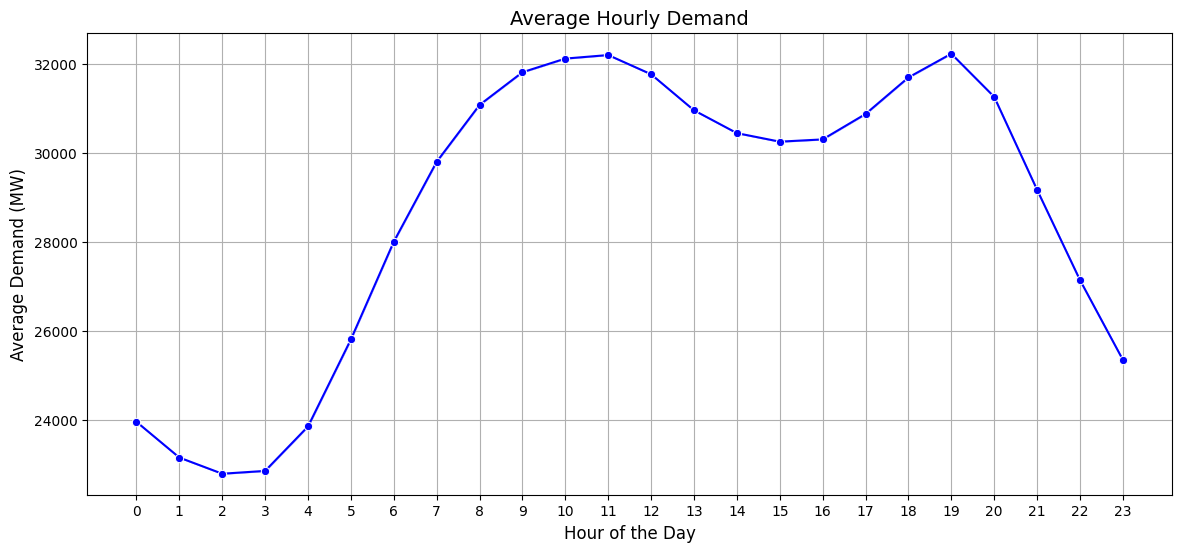

In [ ]:
# Plot hourly demand
plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_df, x='hour', y='avg_hourly_demand', estimator='mean', marker='o', color='blue')
plt.title('Average Hourly Demand', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**The average hourly electricity demand peaks around 11 AM and 7 PM, indicating typical times of increased energy usage.**

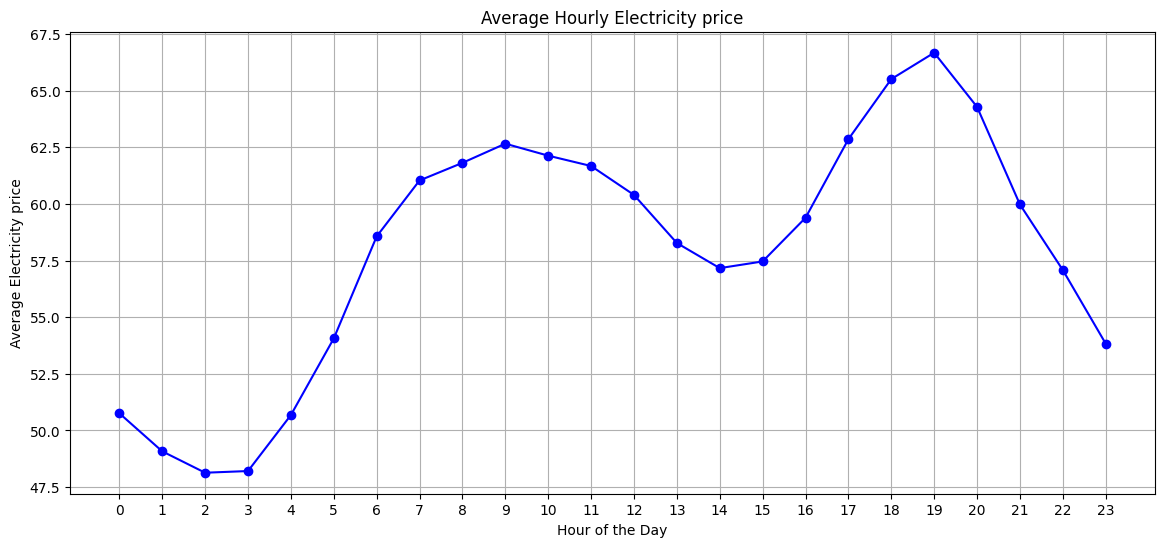

In [ ]:
# Plot the average hourly electricity price
plt.figure(figsize=(14, 6))
plt.plot(hourly_avg_price['hour'], hourly_avg_price['avg_hourly_price'], marker='o', linestyle='-', color='blue')
plt.title('Average Hourly Electricity price')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Electricity price')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

**It can be observed that both the load and price plots look much similar.**

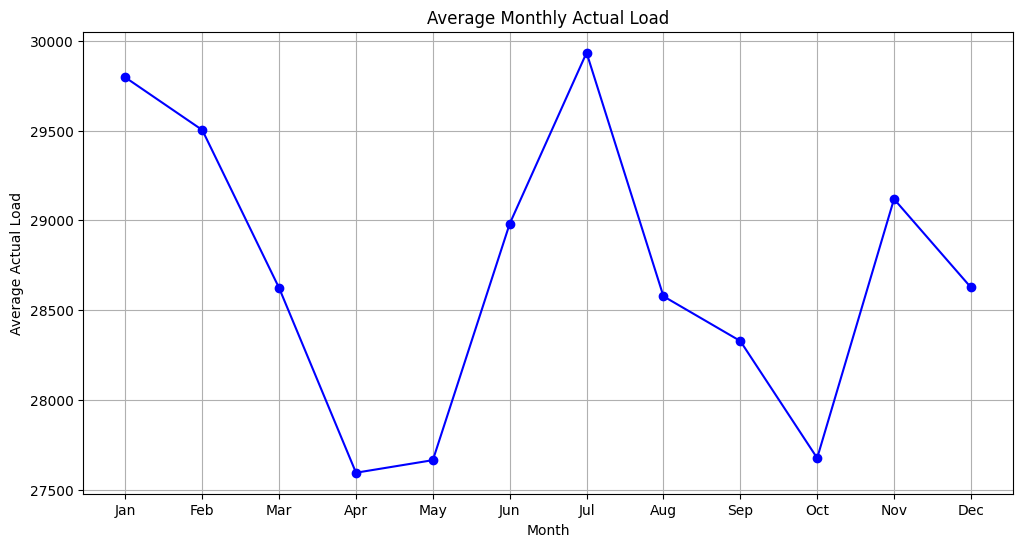

In [ ]:
# Calculate the average actual load for each month across all years
monthly_avg_load = merged_df.groupby('month')['total load actual'].mean().reset_index()

# Plot the average monthly actual load
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_load['month'], monthly_avg_load['total load actual'], marker='o', linestyle='-', color='b')
plt.title('Average Monthly Actual Load')
plt.xlabel('Month')
plt.ylabel('Average Actual Load')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

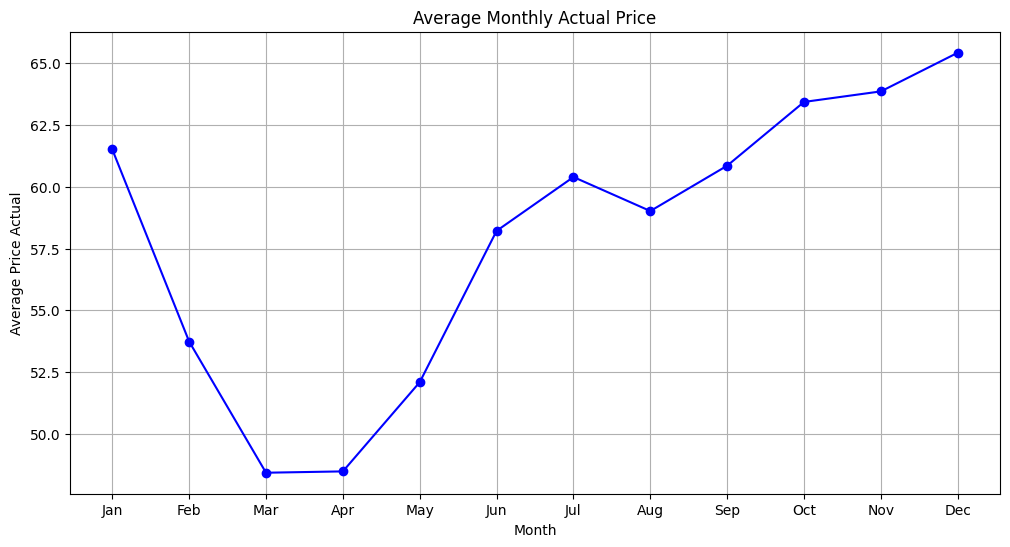

In [ ]:
# Calculate the average actual price for each month across all years
monthly_avg_load = merged_df.groupby('month')['price_actual_interpolated'].mean().reset_index()

# Plot the average monthly actual price
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_load['month'], monthly_avg_load['price_actual_interpolated'], marker='o', linestyle='-', color='b')
plt.title('Average Monthly Actual Price')
plt.xlabel('Month')
plt.ylabel('Average Price Actual')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

Average Electricity Demand by Day of the Week

<ipython-input-111-2c8cd2cf30c7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dayofweek_demand.index, y=dayofweek_demand.values, order=day_order, palette='muted')


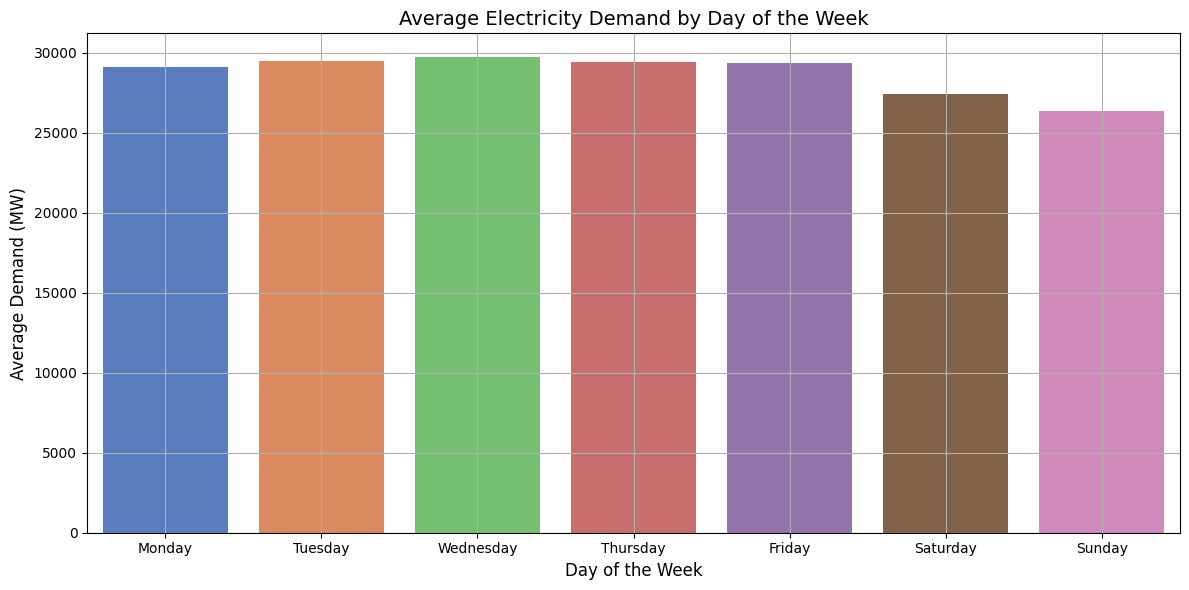

In [ ]:
# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and calculate the mean demand
dayofweek_demand = merged_df.groupby(merged_df['time'].dt.day_name())['total load actual'].mean()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=dayofweek_demand.index, y=dayofweek_demand.values, order=day_order, palette='muted')

# Adding labels and title
plt.title('Average Electricity Demand by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

**The line graph shows higher electricity demand on weekdays compared to Sundays. This is likely because businesses and factories are closed on Sundays.**

Weekend vs. Weekday Demand Comparison

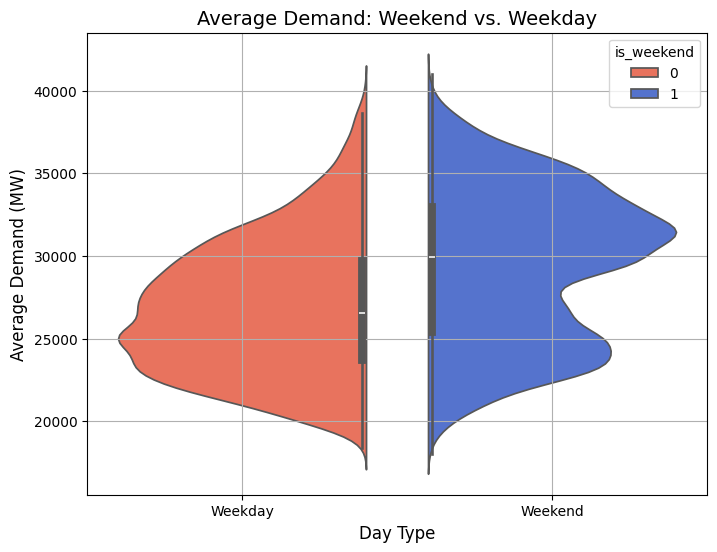

In [ ]:
# Plot weekend vs. weekday demand
plt.figure(figsize=(8, 6))
sns.violinplot(data=merged_df, x='is_weekend', y=demand_column, hue='is_weekend', palette=['#FF6347', '#4169E1'], split=True)
plt.title('Average Demand: Weekend vs. Weekday', fontsize=14)
plt.xlabel('Day Type', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks([0, 1], ['Weekday', 'Weekend'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

**Weekdays have higher electricity demand than weekends due to business operations.**

***Temporal Trends and Seasonality***

Electricity Demand Over Time

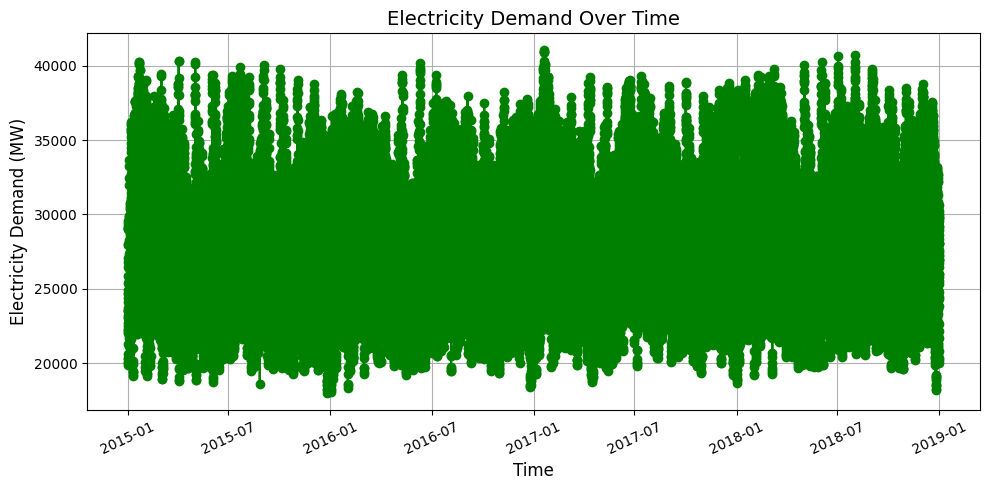

In [ ]:
# Plot of Electricity Demand Over Time
plt.figure(figsize=(10, 5))
plt.plot(merged_df['time'], merged_df[demand_column], marker='o', linestyle='-', color='green')
plt.title('Electricity Demand Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Electricity Demand (MW)', fontsize=12)
plt.xticks(rotation=25, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


**The graph shows gradual increase in electricity demand over four and a half years.**

Counts of Weekdays and Weekends

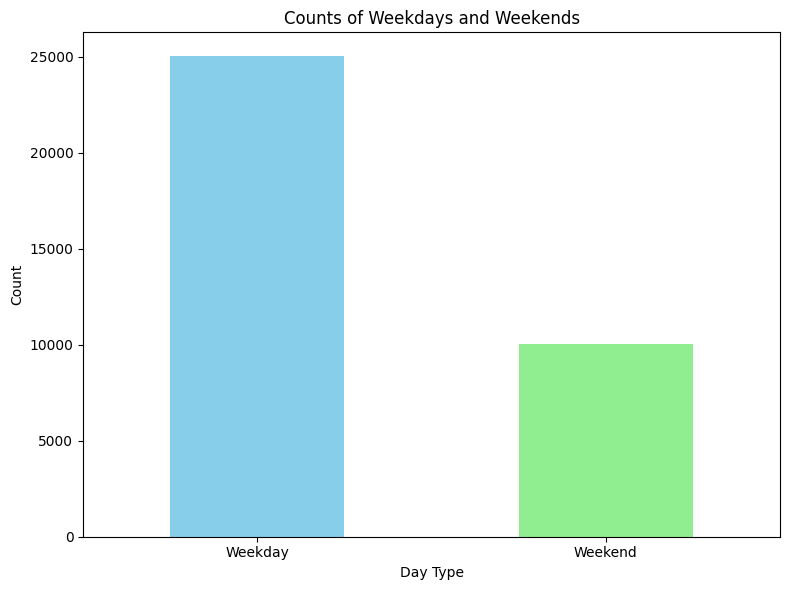

In [ ]:
day_type_counts = merged_df['is_weekend'].value_counts()

plt.figure(figsize=(8, 6))
day_type_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Counts of Weekdays and Weekends')
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.tight_layout()
plt.show()

**The count for weekdays is higher based on the overall increasing trend observed in the graph.**

***Weather and Demand Analysis***

Temperature Distribution

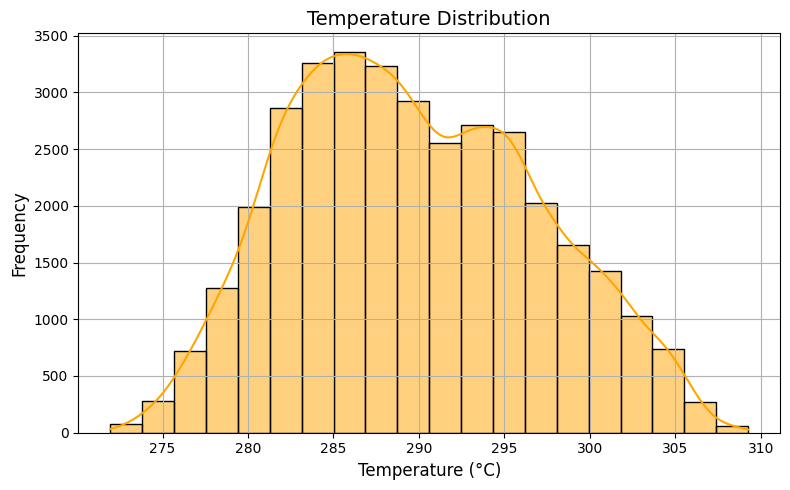

In [ ]:
# Histogram of Temperature Distribution
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['temp'], bins=20, kde=True, color='orange')
plt.title('Temperature Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

**The Histogram shows a gradual increase in temperature in degrees Celsius.**

Average Electricity Demand by Weather Condition

<ipython-input-79-a52434041695>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weather_description', y=demand_column, data=merged_df, estimator=np.mean, palette='Set2')


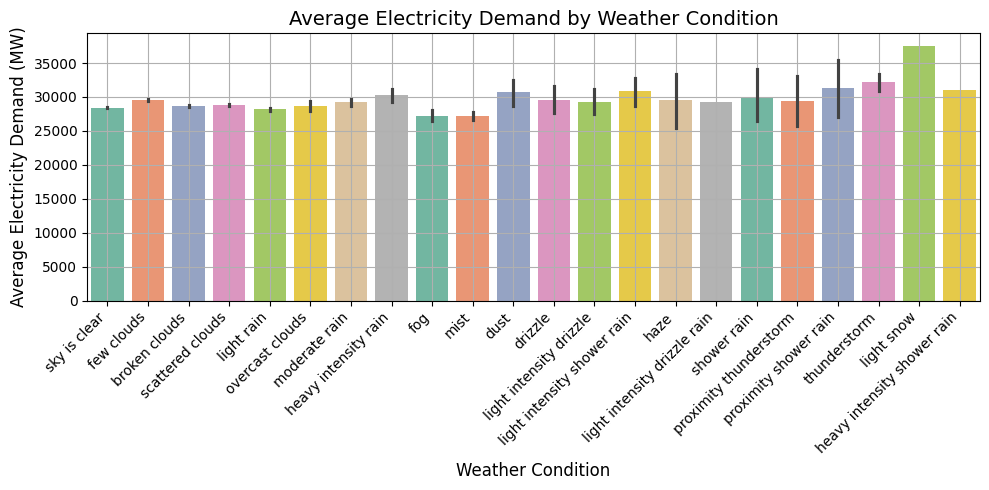

In [ ]:
# Bar Plot of Average Electricity Demand by Weather Condition
plt.figure(figsize=(10, 5))
sns.barplot(x='weather_description', y=demand_column, data=merged_df, estimator=np.mean, palette='Set2')
plt.title('Average Electricity Demand by Weather Condition', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Average Electricity Demand (MW)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

**Examining average electricity demand by weather, this graph suggests a correlation between extreme temperatures (hot or cold) and higher electricity usage.**

***Peak vs. Non-Peak Hours***

Average Electricity Demand During Peak vs. Non-Peak Hours

<ipython-input-114-1afd64042916>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=['blue', 'red'])


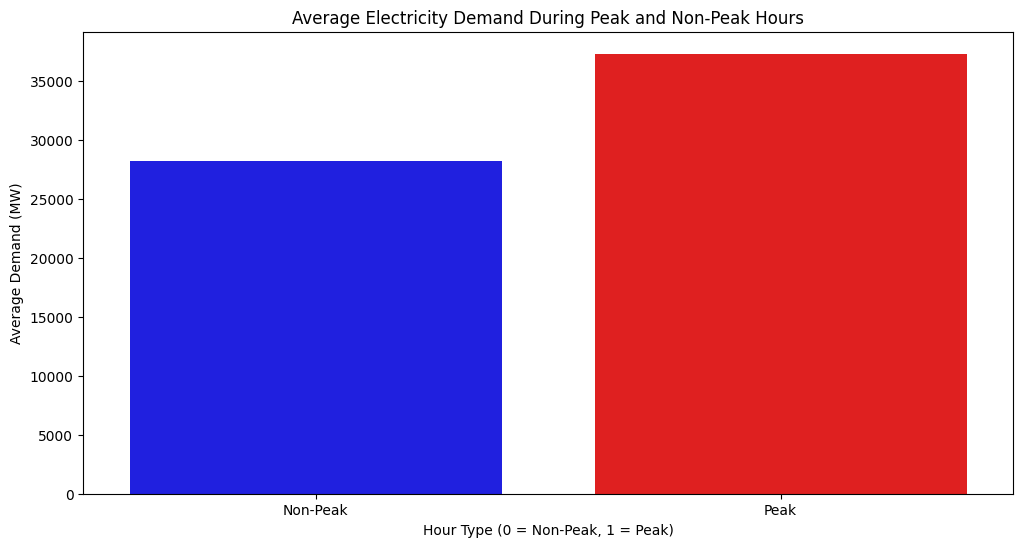

In [ ]:
merged_df['peak_hour'] = merged_df['total load actual'] > merged_df['total load actual'].quantile(0.95)

try:
    peak_demand = merged_df.groupby('peak_hour')['total load actual'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=['blue', 'red'])
    plt.title('Average Electricity Demand During Peak and Non-Peak Hours')
    plt.xlabel('Hour Type (0 = Non-Peak, 1 = Peak)')
    plt.ylabel('Average Demand (MW)')
    plt.xticks(ticks=[0, 1], labels=['Non-Peak', 'Peak'])
    plt.show()

except KeyError as e:
    print(f"KeyError: {str(e)}. Make sure 'peak_hour' column exists and is correctly spelled.")

**Based on the graph, average electricity demand is higher during peak hours than non-peak hours.**

***Additional Insights***

Histogram of Total Load Actual and Price Actual

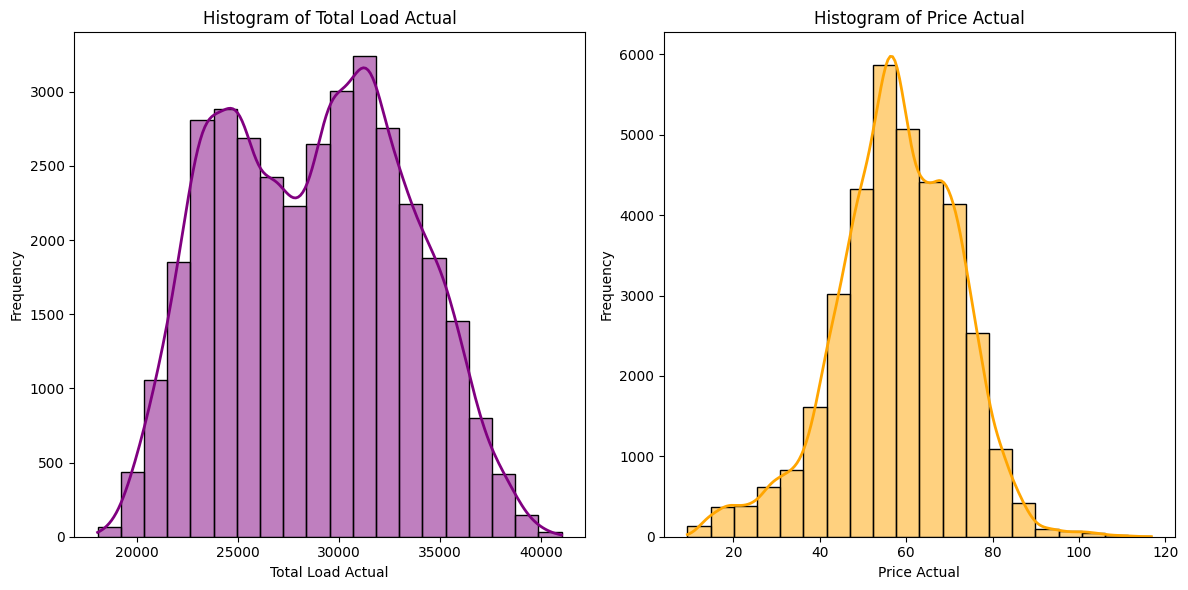

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram for 'total load actual'
plt.subplot(1, 2, 1)
sns.histplot(merged_df['total load actual'], bins=20, kde=True, color='purple', line_kws={'linewidth': 2})
plt.title('Histogram of Total Load Actual')
plt.xlabel('Total Load Actual')
plt.ylabel('Frequency')

# Histogram for 'price actual'
plt.subplot(1, 2, 2)
sns.histplot(merged_df['price actual'], bins=20, kde=True, color='orange', line_kws={'linewidth': 2})
plt.title('Histogram of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Analyzing the histograms, Total Load Actual appears more frequent at higher values compared to Price Actual.**

Average Electricity Demand by Weather Condition

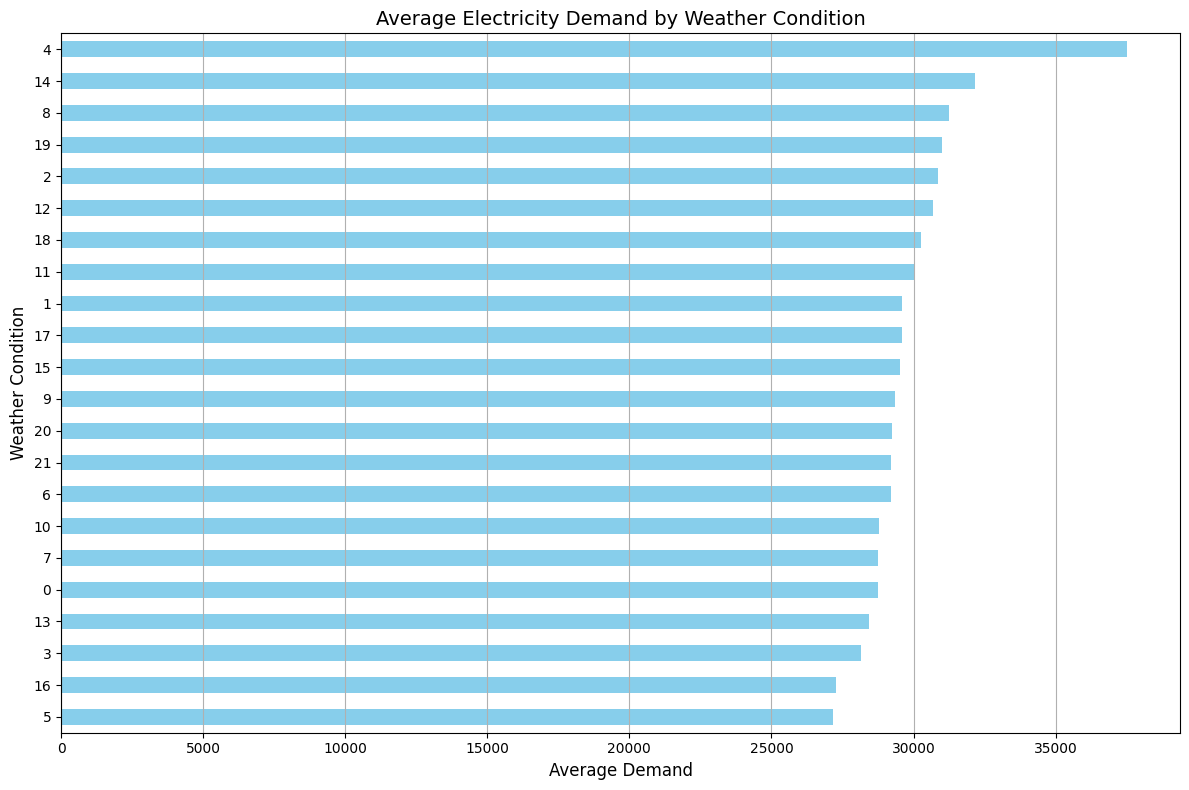

In [ ]:
plt.figure(figsize=(12, 8))

# Sort weather conditions by average demand
avg_demand_by_weather = merged_df.groupby('weather_description')['total load actual'].mean().sort_values()

# Horizontal bar plot
avg_demand_by_weather.plot(kind='barh', color='skyblue')

plt.title('Average Electricity Demand by Weather Condition', fontsize=14)
plt.xlabel('Average Demand', fontsize=12)
plt.ylabel('Weather Condition', fontsize=12)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

plt.tight_layout()
plt.show()


**Shows higher electricity use during extreme weather (hot or cold) compared to moderate temperatures.**

Electricity Demand vs Temperature Scatter Plot

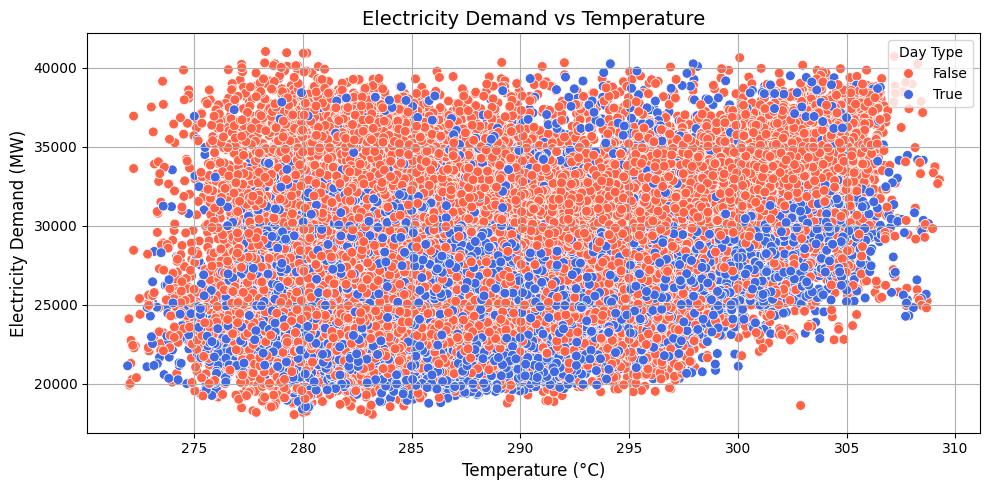

In [ ]:
# Scatter Plot: Electricity Demand vs Temperature
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x='temp', y=demand_column, hue='is_weekend', palette=['#FF6347', '#4169E1'], s=50)
plt.title('Electricity Demand vs Temperature', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Electricity Demand (MW)', fontsize=12)
plt.grid(True)
plt.legend(title='Day Type', loc='upper right')
plt.tight_layout()
plt.show()

**There appears to be a positive correlation between temperature and electricity demand, meaning electricity demand increases as temperature rises.**

Temperature and Demand Correlation Heatmap

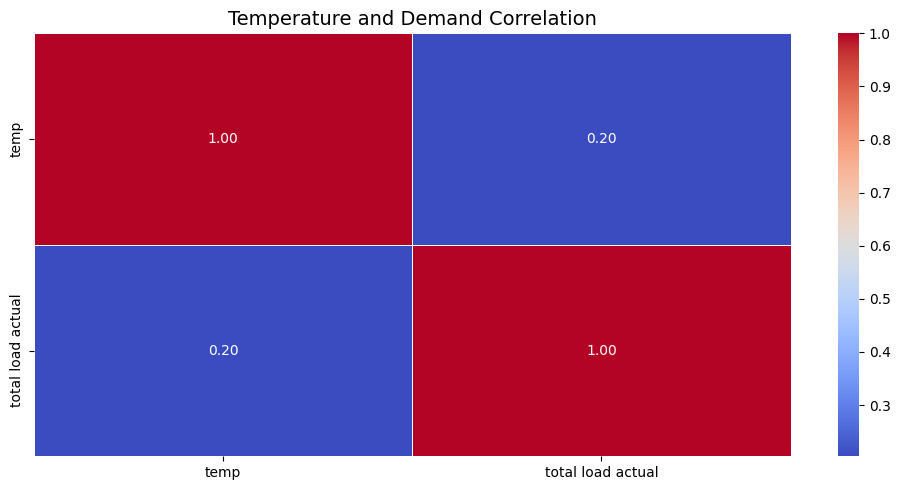

In [ ]:
# Heatmap: Correlation between Temperature and Demand
plt.figure(figsize=(10, 5))
corr = merged_df[['temp', demand_column]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Temperature and Demand Correlation', fontsize=14)
plt.tight_layout()
plt.show()

**This heatmap shows higher electricity demand during hot weather (red) and potentially less during cold weather (blue).**

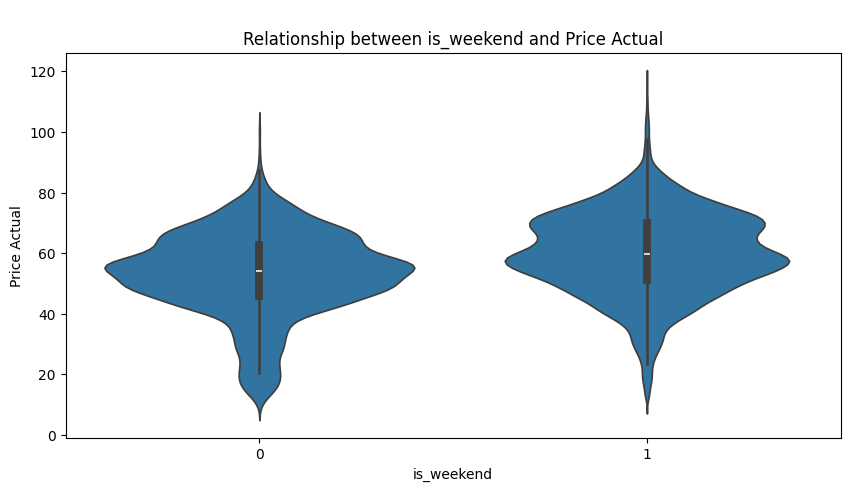

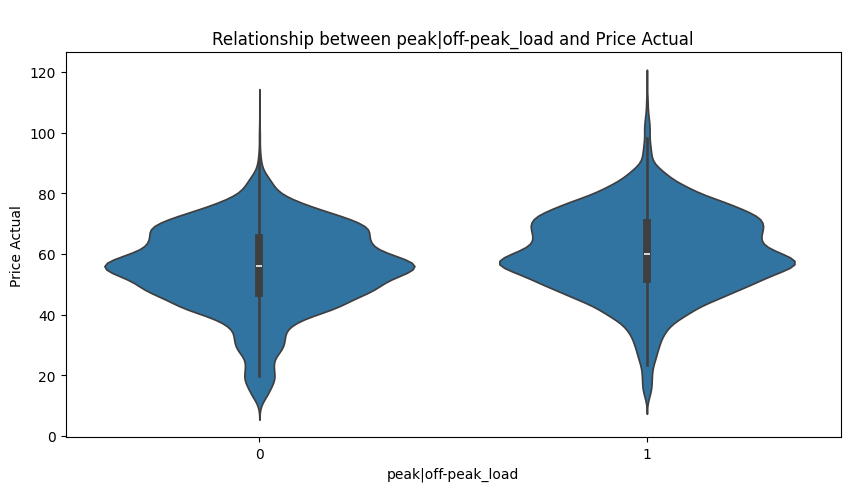

In [ ]:
# Define categorical features
categorical_features = ['is_weekend', 'peak|off-peak_load']

# Plot violin plots for each categorical feature
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=merged_df, x=feature, y='price actual')
    plt.title(f'\nRelationship between {feature} and Price Actual')
    plt.xlabel(feature)
    plt.ylabel('Price Actual')
    plt.show()

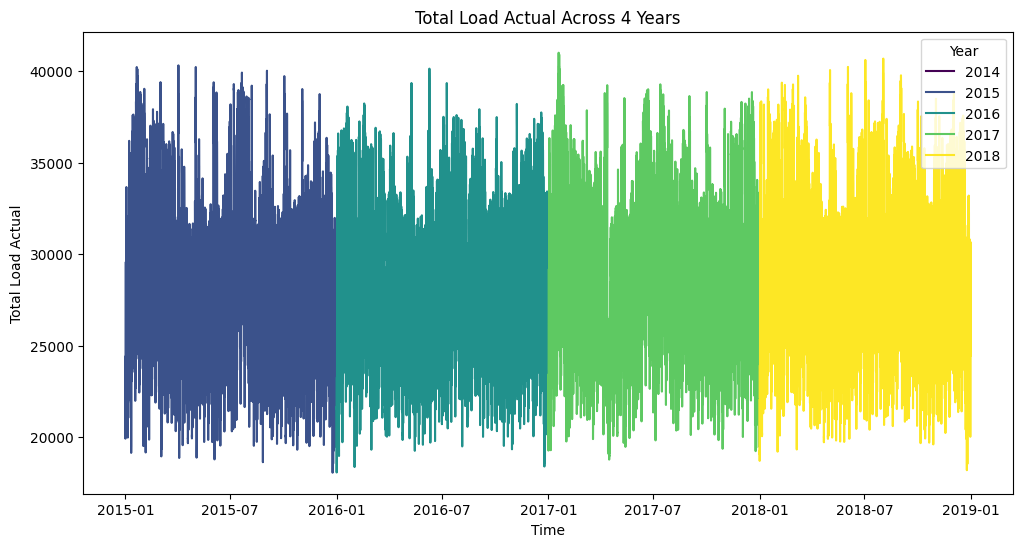

In [ ]:
# Ensure 'time' column is in datetime format
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Extract the year from the 'time' column
merged_df['year'] = merged_df['time'].dt.year

# Plot line plot for total load actual across 4 years with a different color palette
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='time', y='total load actual', hue='year', palette='viridis')
plt.title('Total Load Actual Across 4 Years')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.legend(title='Year')
plt.show()

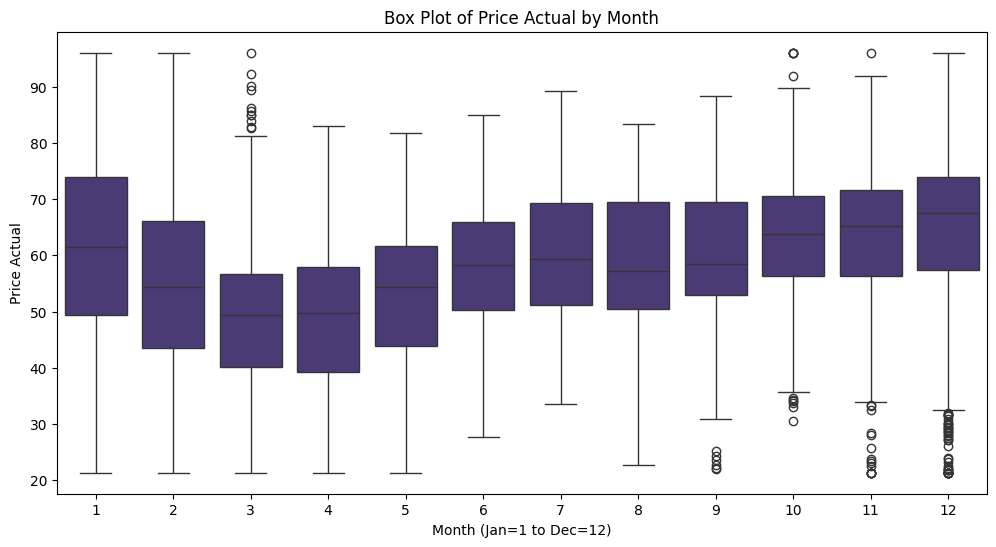

In [ ]:
# Extract the month from the 'time' column
merged_data['month'] = merged_data['time'].dt.month

# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Create a box plot of 'price actual' by month
sns.boxplot(data=merged_data, x='month', y='price actual')

# Add a title to the plot
plt.title('Box Plot of Price Actual by Month')

# Label the x-axis
plt.xlabel('Month (Jan=1 to Dec=12)')

# Label the y-axis
plt.ylabel('Price Actual')

# Display the plot
plt.show()

**There is a clear seasonal pattern in actual prices, with higher values during winter (December, January, February) and summer (June, July, August), likely due to increased heating and cooling demands. Conversely, prices are lower in April and October, reflecting reduced energy consumption during milder weather.**

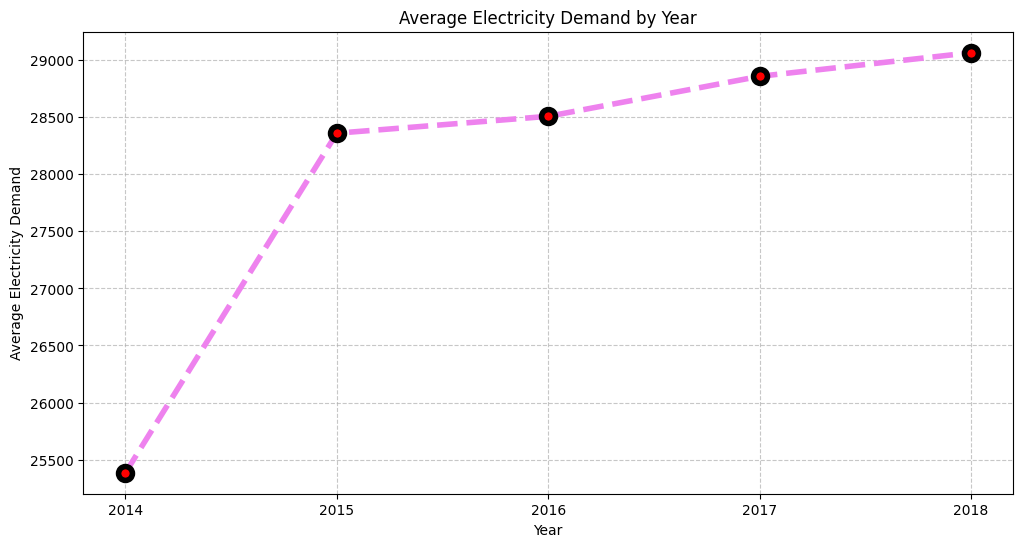

In [ ]:
# Ensure 'time' column is in datetime format
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Extract the year from the 'time' column
merged_df['year'] = merged_df['time'].dt.year

# Group by year and calculate the mean electricity demand for each year
yearly_demand = merged_df.groupby('year')['total load actual'].mean().reset_index()

# Plot the yearly electricity demand
plt.figure(figsize=(12, 6))

plt.plot(yearly_demand['year'], yearly_demand['total load actual'], marker='o', linestyle='--', color='violet', linewidth=4, markersize=10, markerfacecolor='red', markeredgewidth=4, markeredgecolor='black')

plt.xlabel('Year')
plt.ylabel('Average Electricity Demand')
plt.title('Average Electricity Demand by Year')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(yearly_demand['year'])

plt.show()

# Step 8: Correlation Matrix

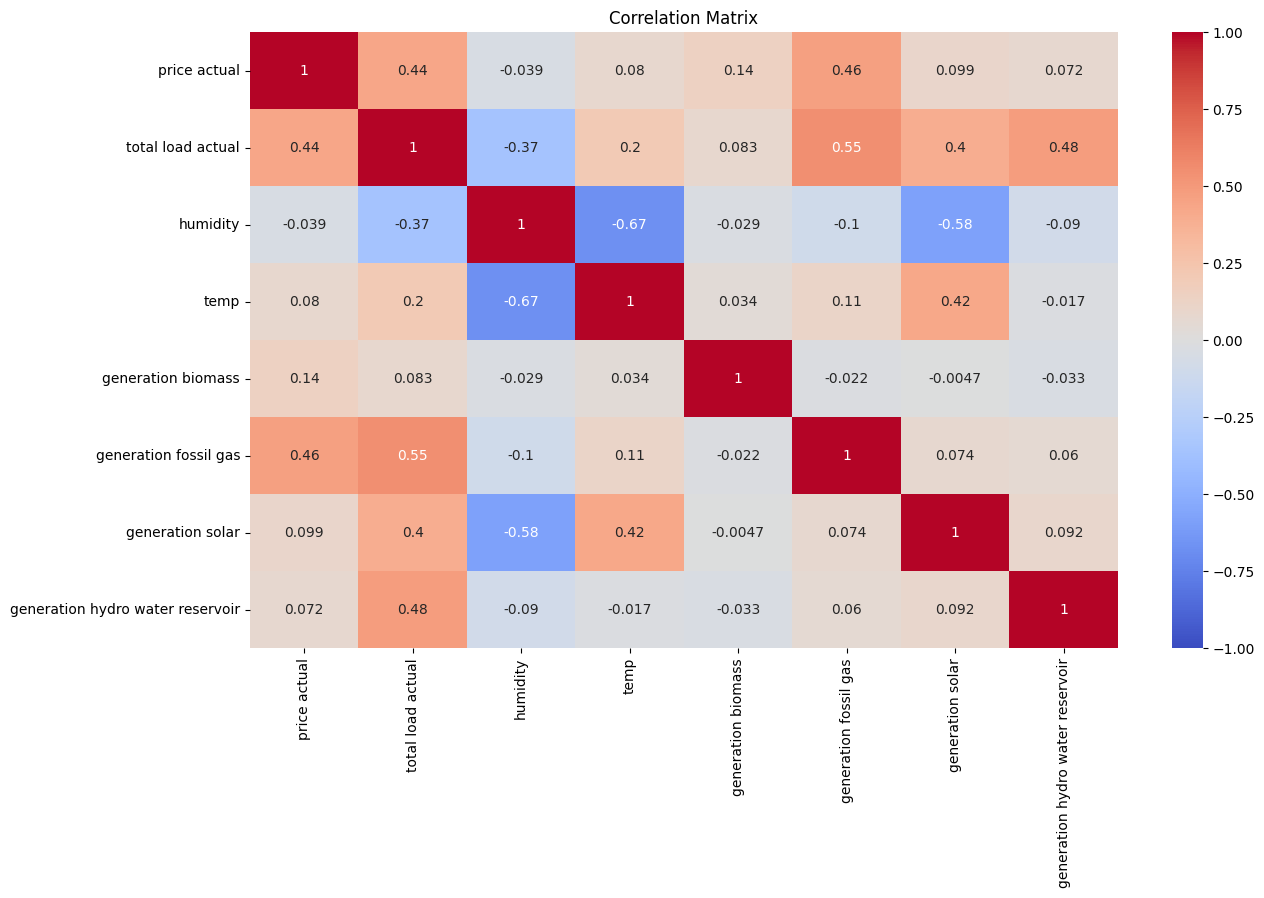

In [ ]:
# Define relevant columns for correlation matrix
columns_of_interest = ['price actual', 'total load actual', 'humidity', 'temp',
                       'generation biomass', 'generation fossil gas',
                       'generation solar', 'generation hydro water reservoir']

# Subset the dataset to include only the columns of interest
subset_data = merged_df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


**Price and Demand Fluctuations:** This plot explores how electricity demand (total load actual) and price (price actual) fluctuate throughout the day and potentially across seasons. The inclusion of variables like temperature and humidity could indicate an investigation into how weather patterns influence these fluctuations. This also defines the correlation between them.

Columns with correlation greater than 0.1 for price actual:
forecast solar day ahead                0.101402
October                                 0.120049
November                                0.125683
generation biomass                      0.142688
December                                0.161130
generation waste                        0.168735
peak|off-peak_load                      0.175879
is_weekend                              0.217831
generation other renewable              0.255544
generation fossil oil                   0.285021
generation fossil brown coal/lignite    0.363986
avg_hourly_demand                       0.364914
avg_hourly_demand_y                     0.364914
avg_hourly_demand_x                     0.364914
avg_hourly_price                        0.388391
total load actual                       0.435573
total load forecast                     0.435864
generation fossil gas                   0.461423
generation fossil hard coal             0.465648
price day

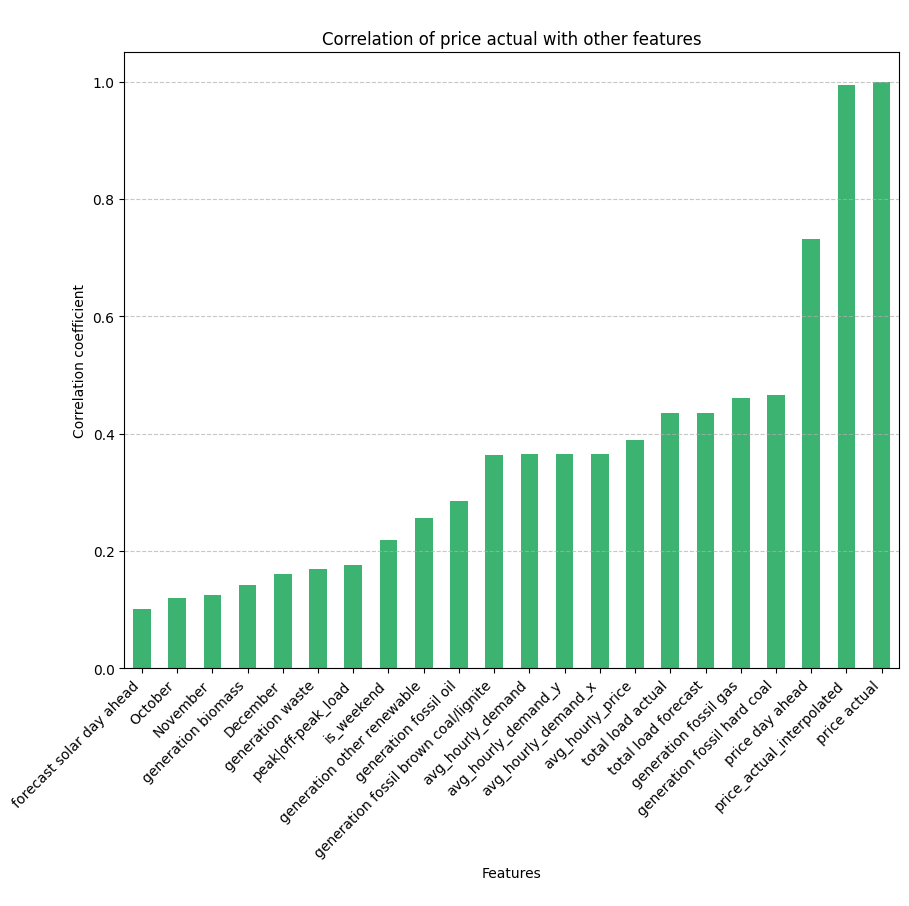

Columns with correlation greater than 0.1 for total load actual:
generation other                              0.100768
generation hydro run-of-river and poundage    0.118340
generation other renewable                    0.180955
wind_speed                                    0.194858
temp_max                                      0.198534
temp                                          0.203489
temp_min                                      0.203735
is_weekend                                    0.250964
generation fossil brown coal/lignite          0.280729
generation solar                              0.395609
generation fossil hard coal                   0.396947
forecast solar day ahead                      0.404001
price actual                                  0.435573
price_actual_interpolated                     0.436888
price day ahead                               0.474102
generation hydro water reservoir              0.479253
generation fossil oil                         0.496173


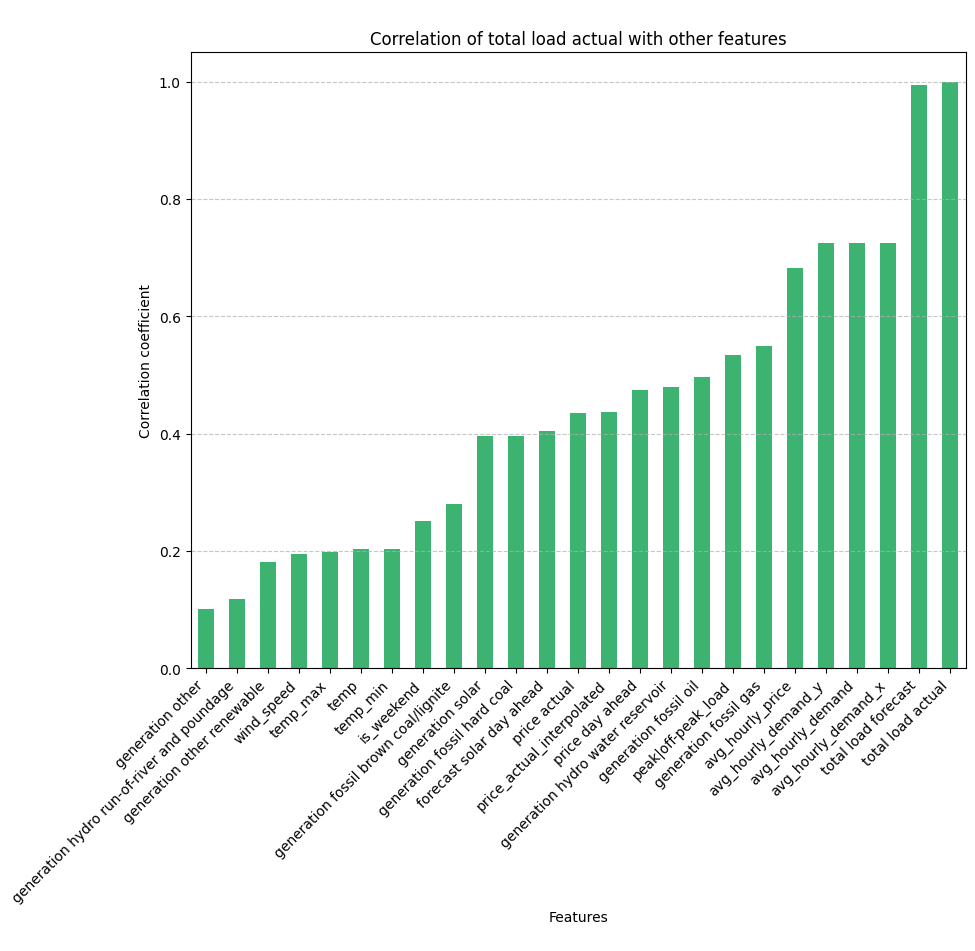

Common columns with correlation greater than 0.1 for both target variables:
{'avg_hourly_price', 'generation fossil gas', 'avg_hourly_demand_y', 'price actual', 'forecast solar day ahead', 'generation other renewable', 'peak|off-peak_load', 'avg_hourly_demand_x', 'generation fossil brown coal/lignite', 'price_actual_interpolated', 'generation fossil oil', 'generation fossil hard coal', 'is_weekend', 'total load forecast', 'avg_hourly_demand', 'price day ahead', 'total load actual'}
Number of common columns: 17


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the target columns
target_columns = ['price actual', 'total load actual']

# Initialize a dictionary to hold positive correlations for each target column
positive_correlations_dict = {}

# Ensure numeric columns for correlation calculation
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])

for target_column in target_columns:
    if target_column in numeric_df.columns:
        # Calculate correlations of the target column with all other columns
        correlations = numeric_df.corr()[target_column].sort_values()

        # Filter out correlations greater than 0.1
        positive_correlations = correlations[correlations > 0.1]
        positive_correlations_dict[target_column] = set(positive_correlations.index)

        # Print the columns with correlations greater than 0.1
        print(f"Columns with correlation greater than 0.1 for {target_column}:")
        print(positive_correlations)

        # Plot the correlations
        plt.figure(figsize=(10, 8))
        positive_correlations.plot(kind='bar', color='mediumseagreen')
        plt.title(f'\nCorrelation of {target_column} with other features')
        plt.xlabel('Features\n')
        plt.ylabel('\nCorrelation coefficient')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# Find the common columns that have a correlation greater than 0.1 for both target variables
common_columns = set.intersection(*positive_correlations_dict.values())

# Print the common columns
print("Common columns with correlation greater than 0.1 for both target variables:")
print(common_columns)
print("Number of common columns:", len(common_columns))

# Step 9: Labeled Regression Line Plot

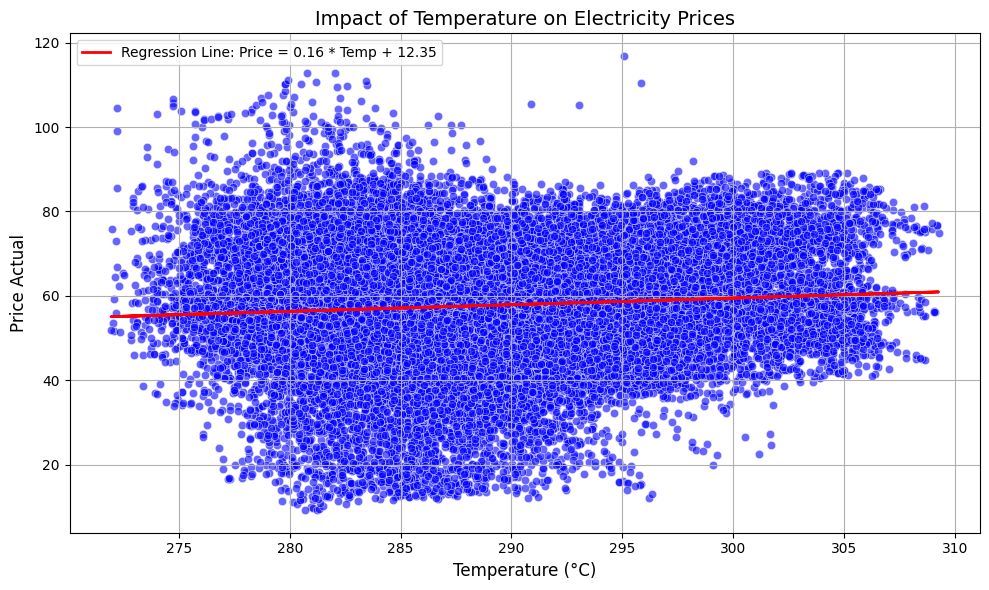

In [ ]:
merged_df['time'] = pd.to_datetime(merged_df['time'], errors='coerce')

# Perform linear regression
X = merged_df[['temp']]  # Temperature as input feature
y = merged_df['price actual']  # Price actual as target variable
reg = LinearRegression().fit(X, y)

y_pred = reg.predict(X)

plt.figure(figsize=(10, 6))

# Scatter plot of price vs temp
sns.scatterplot(x='temp', y='price actual', data=merged_df, color='b', alpha=0.6)

# Regression line with label
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression Line: Price = {reg.coef_[0]:.2f} * Temp + {reg.intercept_:.2f}')

plt.title('Impact of Temperature on Electricity Prices', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Price Actual', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

**This scatter plot shows a positive correlation between temperature and electricity prices. Warmer weather likely means higher electricity demand for cooling, pushing prices up.**

In [ ]:
# Initialize a dictionary to store label encoders for each categorical column
label_encoder = {}

# Iterate through each column in the dataframe that has object dtype (categorical columns)
for column in merged_df.select_dtypes(include=['object']).columns:
    # Create a LabelEncoder instance for the column
    label_encoder[column] = LabelEncoder()

    # Check if the column contains mixed types and convert to string if necessary
    if merged_df[column].apply(type).nunique() > 1:
        merged_df[column] = merged_df[column].astype(str)

    # Apply label encoding to the column
    merged_df[column] = label_encoder[column].fit_transform(merged_df[column])

# Now merged_df contains encoded values for categorical columns

In [ ]:
merged_df.drop(columns=['time'],inplace=True)

# Step 10: Recursive Feature Elimination (RFE) Method

In [ ]:
# Define the feature columns for load and price forecasting
features_demand = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead','total load forecast', 'price day ahead', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all', 'peak|off-peak_load']]

features_price = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead','total load forecast', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all', 'peak|off-peak_load']]

target_demand = merged_df['total load actual']
target_price = merged_df['price actual']

# Split the dataset into training and testing sets for load forecasting
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.3, random_state=40)
# Split the dataset into training and testing sets for price forecasting
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.3, random_state=40)

Feature Selection For Load Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for load prediction with a specific number of features
n_features_to_select = 40
rfe_demand = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_demand.fit(X_train_demand, y_train_demand)

selected_features_demand = X_train_demand.columns[rfe_demand.support_]
print("Selected features for load prediction:", selected_features_demand)

Selected features for load prediction: Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation nuclear', 'generation other', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'snow_3h', 'clouds_all', 'peak|off-peak_load'],
      dtype='object')


Feature Selection For Price Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for price prediction with a specific number of features
n_features_to_select = 40
rfe_price = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_price.fit(X_train_price, y_train_price)

selected_features_price = X_train_price.columns[rfe_price.support_]
print("Selected features for price prediction:", selected_features_price)

Selected features for price prediction: Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation nuclear', 'generation other', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'peak|off-peak_load'],
      dtype='object')


In [ ]:
# Define the feature columns for load forecasting
features_demand = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation other', 'generation solar', 'forecast solar day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'peak|off-peak_load']]

# Define the feature columns for price forecasting
features_price = merged_df[['generation biomass', 'generation fossil gas',
       'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation other renewable', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation other',
       'generation waste', 'forecast solar day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'peak|off-peak_load']]

# Define the target variable for load forecasting
target_demand = merged_df['total load actual']

# Define the target variable for price forecasting
target_price = merged_df['price actual']

# Split the dataset into training and testing sets for load forecasting
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.3, random_state=40)

# Split the dataset into training and testing sets for price forecasting
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.3, random_state=40)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for load prediction with a specific number of features
n_features_to_select = 40
rfe_demand = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_demand.fit(X_train_demand, y_train_demand)

# Get selected features for load prediction
selected_features_demand = X_train_demand.columns[rfe_demand.support_]
print("Selected features for load prediction:", selected_features_demand)

# Feature selection using RFE for price prediction with a specific number of features
rfe_price = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_price.fit(X_train_price, y_train_price)

# Get selected features for price prediction
selected_features_price = X_train_price.columns[rfe_price.support_]
print("\nSelected features for price prediction:", selected_features_price)

Selected features for load prediction: Index(['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation other', 'generation solar', 'forecast solar day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'peak|off-peak_load'],
      dtype='object')

Selected features for price prediction: Index(['generation biomass', 'generation fossil gas',
       'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation other renewable', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation other',
       'generation waste', 'forecast solar day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 's

In [ ]:
features_demand = merged_df[['generation fossil oil', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'pressure', 'wind_speed', 'rain_1h', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'hour']]

features_price = merged_df[['generation other renewable', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'hour']]

target_demand = merged_df['total load actual']
target_price = merged_df['price actual']

In [ ]:
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.3, random_state=40)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.3, random_state=40)

# Step 11: Linear Regression Model

For Load Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training set
lr_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_demand)

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lr = mean_absolute_percentage_error(y_test_demand, y_pred_lr)
print(f'Linear Regression for Load \n  MAPE : {mape_lr * 100:.2f}%')

# Calculate Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test_demand, y_pred_lr)
print(f'  MAE : {mae_lr:.2f}')

# Calculate Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test_demand, y_pred_lr))
print(f'  RMSE : {rmse_lr:.2f}')

# Calculate R-squared (R^2)
r2_lr = r2_score(y_test_demand, y_pred_lr)
print(f'  R2 : {r2_lr:.2f}')

# Function to calculate Adjusted R-squared
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calculate Adjusted R-squared
adjusted_r2_lr = adjusted_r2_score(r2_lr, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_lr:.2f}')


Linear Regression for Load 
  MAPE : 1.10%
  MAE : 314.41
  RMSE : 474.47
  R2 : 0.99
  Adjusted R2 : 0.99


Actual vs Predicted Electricity Load (Linear Regression Model)


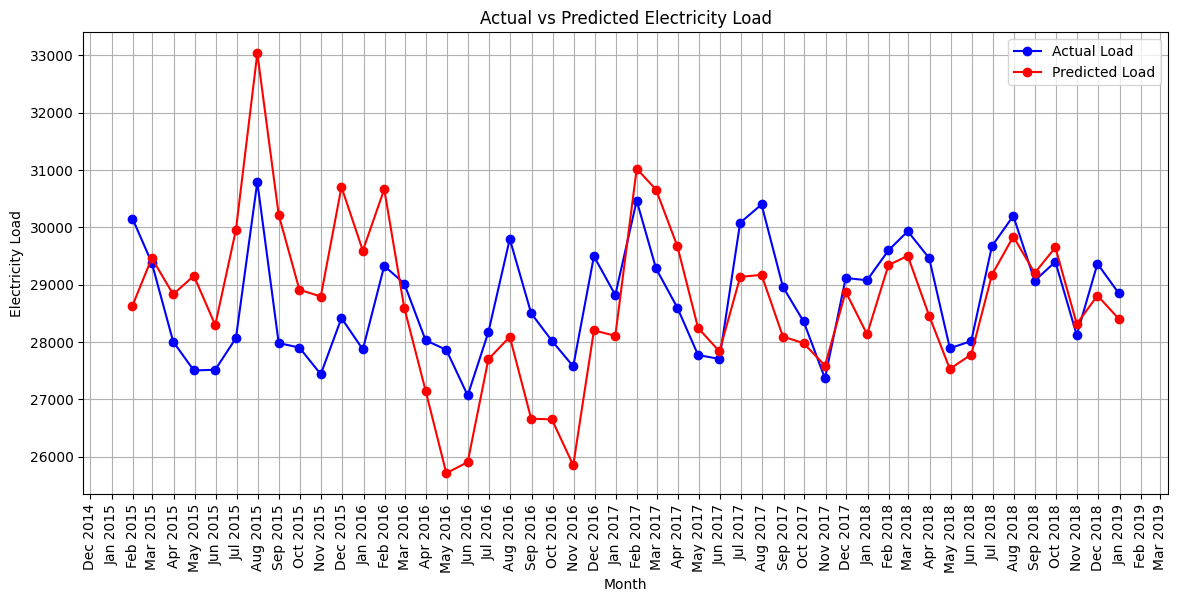

In [ ]:
#Actual vs Predicted Electricity Load
import matplotlib.dates as mdates

lr_model = LinearRegression()
lr_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_demand)
print("Actual vs Predicted Electricity Load (Linear Regression Model)")

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_lr})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training set for price prediction
lr_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_price)

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lr = mean_absolute_percentage_error(y_test_price, y_pred_lr)
print(f'Linear Regression for Price \n  MAPE : {mape_lr * 100:.2f}%')

# Calculate Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test_price, y_pred_lr)
print(f'  MAE : {mae_lr:.2f}')

# Calculate Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test_price, y_pred_lr))
print(f'  RMSE : {rmse_lr:.2f}')

# Calculate R-squared (R^2)
r2_lr = r2_score(y_test_price, y_pred_lr)
print(f'  R2 : {r2_lr:.2f}')

# Calculate Adjusted R-squared
adjusted_r2_lr = adjusted_r2_score(r2_lr, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_lr:.2f}')

Linear Regression for Price 
  MAPE : 15.76%
  MAE : 7.73
  RMSE : 9.86
  R2 : 0.53
  Adjusted R2 : 0.53


Actual vs Predicted Electricity Price (Linear Regression Model)


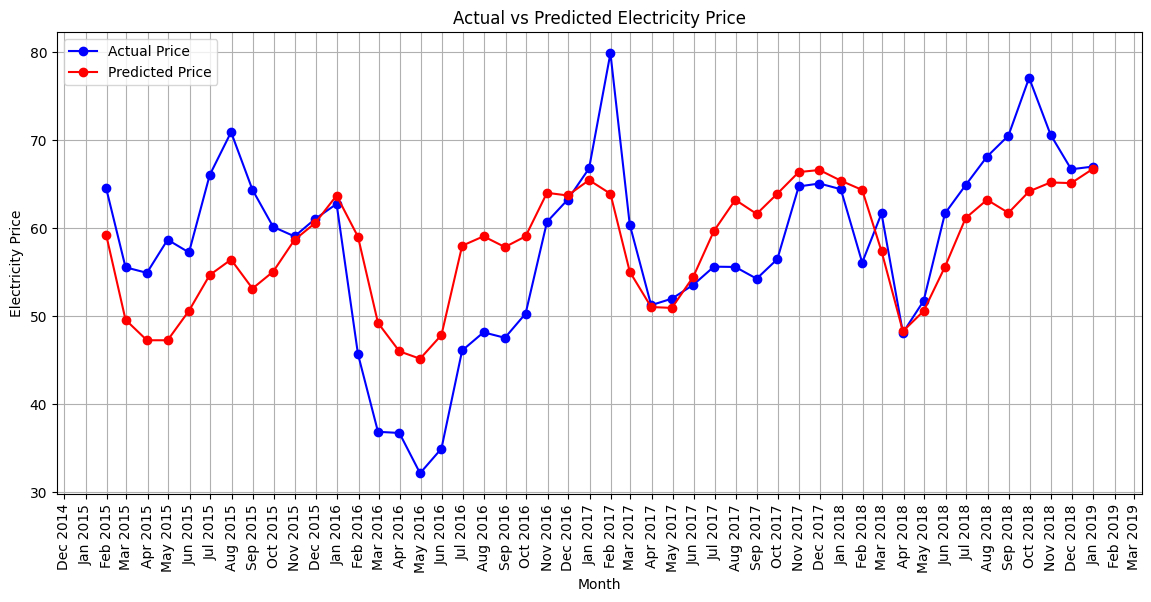

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_price)

print("Actual vs Predicted Electricity Price (Linear Regression Model)")

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_lr})

results_df.set_index('Date', inplace=True)

monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 12: Decision Tree Model

For Load Prediction

In [ ]:
# Initialize the Decision Tree Regressor model with a random state for reproducibility
dt_model = DecisionTreeRegressor(random_state=40)

# Train the model on the training set
dt_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_demand)

# Calculate the errors
mape_dt = mean_absolute_percentage_error(y_test_demand, y_pred_dt)
print(f'Decision Tree for Load \n  MAPE : {mape_dt * 100:.2f}%')

mae_dt = mean_absolute_error(y_test_demand, y_pred_dt)
print(f'  MAE : {mae_dt:.2f}')

rmse_dt = np.sqrt(mean_squared_error(y_test_demand, y_pred_dt))
print(f'  RMSE : {rmse_dt:.2f}')

r2_dt = r2_score(y_test_demand, y_pred_dt)
print(f'  R2 : {r2_dt:.2f}')

adjusted_r2_dt = adjusted_r2_score(r2_dt, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_dt:.2f}')

Decision Tree for Load 
  MAPE : 1.45%
  MAE : 417.40
  RMSE : 606.89
  R2 : 0.98
  Adjusted R2 : 0.98


Actual vs Predicted Electricity Load (Decision Tree Model)


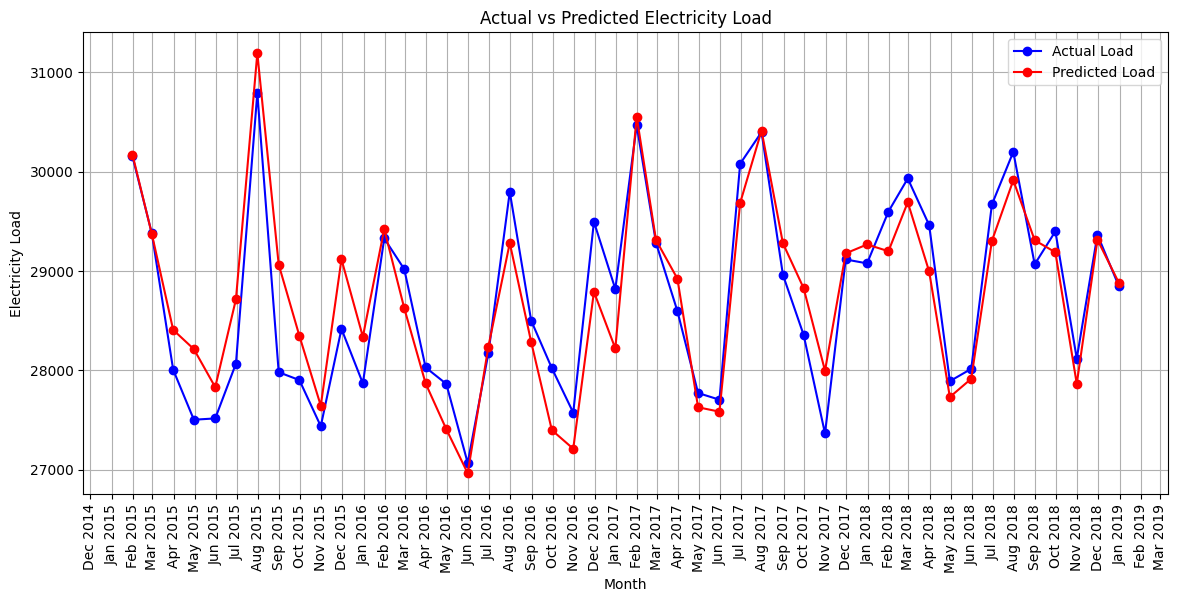

In [ ]:
dt_model = DecisionTreeRegressor(random_state=40)
dt_model.fit(X_train_demand, y_train_demand)

y_pred_dt = dt_model.predict(X_test_demand)

#Actual vs Predicted Electricity Load
print("Actual vs Predicted Electricity Load (Decision Tree Model)")

test_indices = X_test_demand.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_dt})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
# Initialize the Decision Tree Regressor model with a random state for reproducibility
dt_model = DecisionTreeRegressor(random_state=40)

# Train the model on the training set
dt_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_price)

# Calculate the errors
mape_dt = mean_absolute_percentage_error(y_test_price, y_pred_dt)
print(f'Decision Tree for Price \n  MAPE : {mape_dt * 100:.2f}%')

mae_dt = mean_absolute_error(y_test_price, y_pred_dt)
print(f'  MAE : {mae_dt:.2f}')

rmse_dt = np.sqrt(mean_squared_error(y_test_price, y_pred_dt))
print(f'  RMSE : {rmse_dt:.2f}')

r2_dt = r2_score(y_test_price, y_pred_dt)
print(f'  R2 : {r2_dt:.2f}')

adjusted_r2_dt = adjusted_r2_score(r2_dt, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_dt:.2f}')

Decision Tree for Price
  MAPE : 9.26%
  MAE : 4.68
  RMSE : 7.42
  R2 : 0.73
  Adjusted R2 : 0.73


Actual vs Predicted Electricity Price (Decision Tree Model)


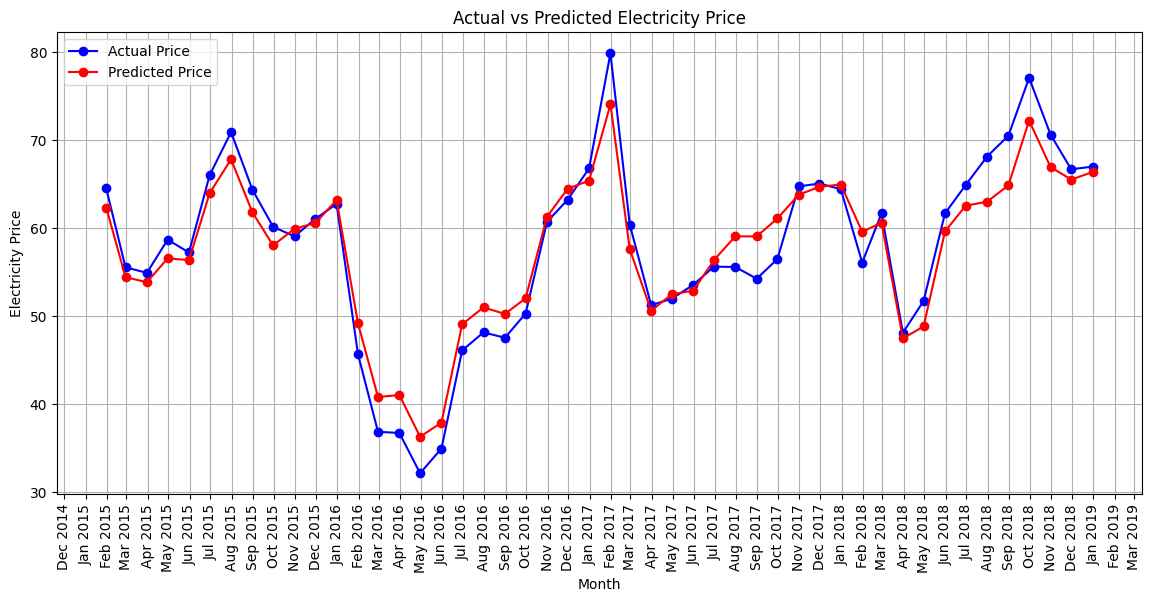

In [ ]:
dt_model = DecisionTreeRegressor(random_state=40)
dt_model.fit(X_train_price, y_train_price)

y_pred_dt = dt_model.predict(X_test_price)

#Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price (Decision Tree Model)")

test_indices = X_test_price.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)

results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_dt})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 13: Random Forest Model (without parameter tuning)

For Load Prediction

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=40)

# Fit the model on the training data
rf_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_demand)

# Calculate metrics
mape_rf = mean_absolute_percentage_error(y_test_demand, y_pred_rf)
mae_rf = mean_absolute_error(y_test_demand, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf))
r2_rf = r2_score(y_test_demand, y_pred_rf)

adjusted_r2_rf = adjusted_r2_score(r2_rf, X_test_demand.shape[0], X_test_demand.shape[1])

# Print metrics
print(f'Random Forest for Load \n  MAPE : {mape_rf * 100:.2f}%')
print(f'  MAE : {mae_rf:.2f}')
print(f'  RMSE : {rmse_rf:.2f}')
print(f'  R2 : {r2_rf:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf:.2f}')

Random Forest for Load 
  MAPE : 1.03%
  MAE : 295.21
  RMSE : 450.86
  R2 : 0.99
  Adjusted R2 : 0.99


Actual vs Predicted Electricity Load (Random Forest Model)


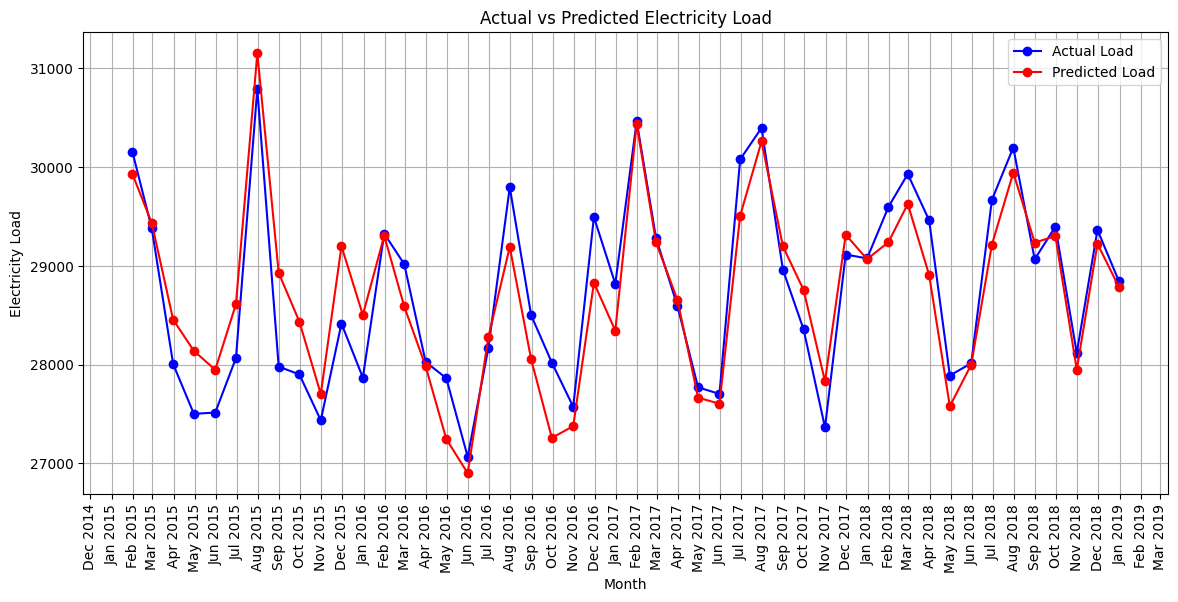

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_demand, y_train_demand)

y_pred_rf = rf_model.predict(X_test_demand)

#Actual vs Predicted Electricity Load
print("Actual vs Predicted Electricity Load (Random Forest Model)")

test_indices = X_test_demand.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_rf})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
# Initialize the Random Forest Regressor model with a random state for reproducibility
rf_model = RandomForestRegressor(random_state=40)

# Fit the model on the training data for price prediction
rf_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_price)

# Calculate the errors
mape_rf = mean_absolute_percentage_error(y_test_price, y_pred_rf)
print(f'Random Forest for Price \n  MAPE : {mape_rf * 100:.2f}%')

mae_rf = mean_absolute_error(y_test_price, y_pred_rf)
print(f'  MAE : {mae_rf:.2f}')

rmse_rf = np.sqrt(mean_squared_error(y_test_price, y_pred_rf))
print(f'  RMSE : {rmse_rf:.2f}')

r2_rf = r2_score(y_test_price, y_pred_rf)
print(f'  R2 : {r2_rf:.2f}')

adjusted_r2_rf = adjusted_r2_score(r2_rf, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_rf:.2f}')

Random Forest for Price 
  MAPE : 6.92%
  MAE : 3.41
  RMSE : 4.90
  R2 : 0.88
  Adjusted R2 : 0.88


Actual vs Predicted Electricity Price (Random Forest Model)


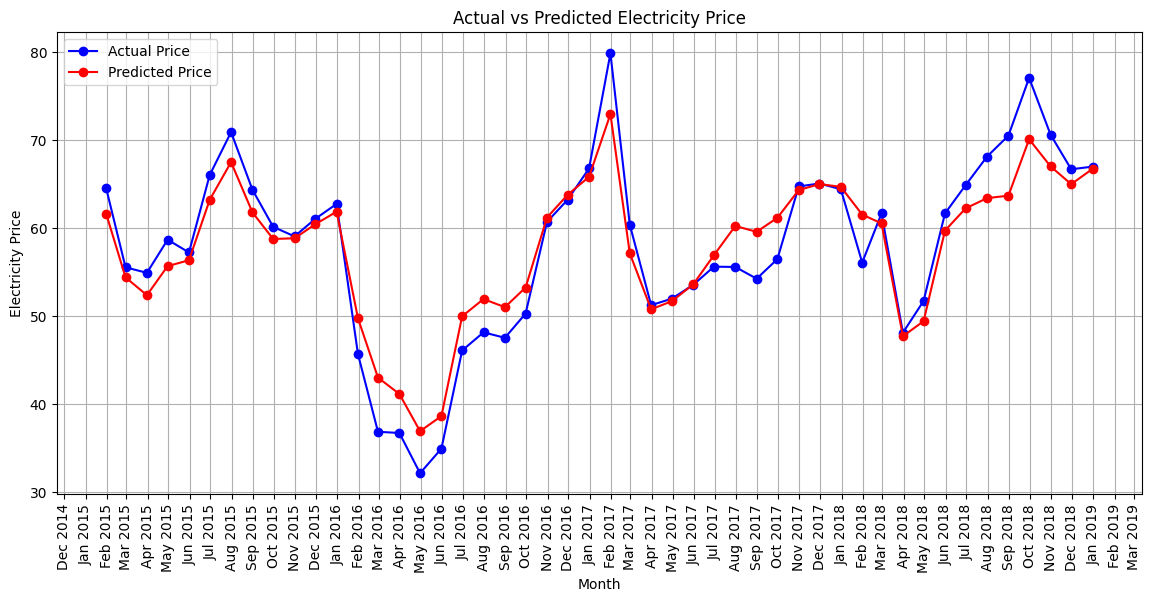

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_price, y_train_price)

y_pred_rf = rf_model.predict(X_test_price)

#Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price (Random Forest Model)")

test_indices = X_test_price.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_rf})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 14: Random Forest Model (with parameter tuning)

For Load Prediction

In [ ]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=40)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_rf.fit(X_train_demand, y_train_demand.ravel())

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("\n\nBest score for Random Forest:", best_score_rf)

# Use the best estimator to make predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tun = best_rf_model.predict(X_test_demand)

# Calculate MAPE
mape_rf_tun = mean_absolute_percentage_error(y_test_demand, y_pred_rf_tun)
print(f'\nRandom Forest(Tuned) for Load \n  MAPE : {mape_rf_tun * 100:.2f}%')

# Calculate MAE
mae_rf_tun = mean_absolute_error(y_test_demand, y_pred_rf_tun)
print(f'  MAE : {mae_rf_tun:.2f}')

# Calculate RMSE
rmse_rf_tun = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf_tun))
print(f'  RMSE  : {rmse_rf_tun:.2f}')

# Calculate R^2
r2_rf_tun = r2_score(y_test_demand, y_pred_rf_tun)
print(f'  R2  : {r2_rf_tun:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf_tun = adjusted_r2_score(r2_rf_tun, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2  : {adjusted_r2_rf_tun:.2f}')

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   7.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   6.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  18.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_sample

Actual vs Predicted Electricity Load (Random Forest Model with HP tuning))


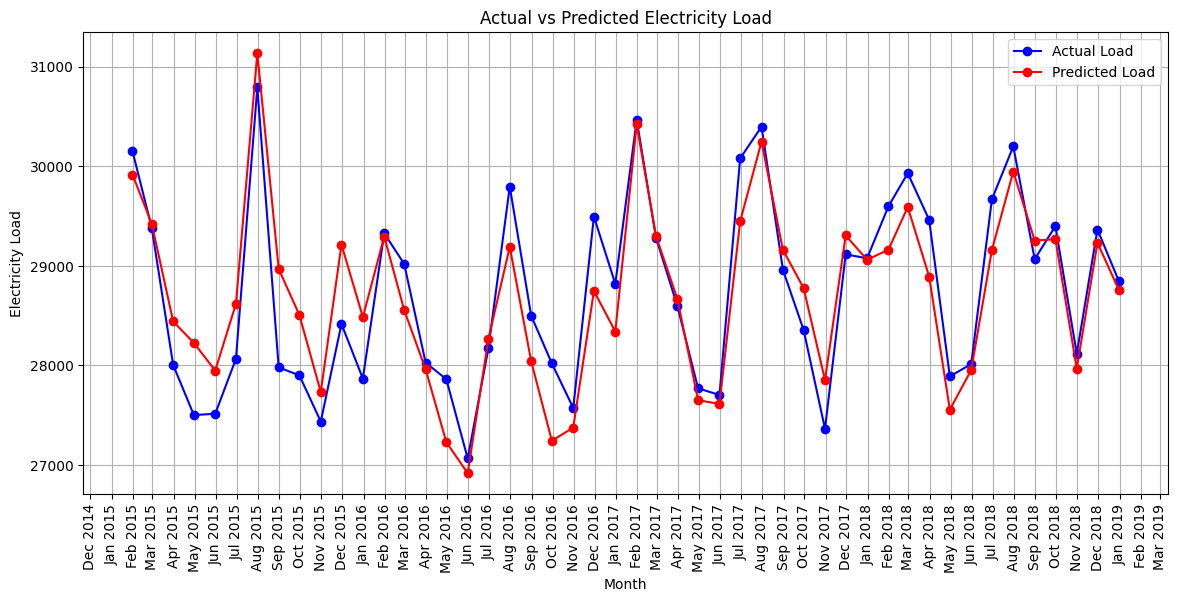

In [ ]:
#Actual vs Predicted Electricity Load
print("Actual vs Predicted Electricity Load (Random Forest Model with HP tuning))")

test_indices = X_test_demand.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_rf_tun})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=40)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_rf.fit(X_train_price, y_train_price.ravel())

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters for Random Forest (Price) :", best_params_rf)
print("\n\nBest score for Random Forest (Price) :", best_score_rf)

# Use the best estimator to make predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tun = best_rf_model.predict(X_test_price)

# Calculate MAPE
mape_rf_tun_p = mean_absolute_percentage_error(y_test_price, y_pred_rf_tun)
print(f'\nRandom Forest(Tuned) for Price \n  MAPE : {mape_rf_tun_p * 100:.2f}%')

# Calculate MAE
mae_rf_tun_p = mean_absolute_error(y_test_price, y_pred_rf_tun)
print(f'  MAE : {mae_rf_tun_p:.2f}')

# Calculate RMSE
rmse_rf_tun_p = np.sqrt(mean_squared_error(y_test_price, y_pred_rf_tun))
print(f'  RMSE : {rmse_rf_tun_p:.2f}')

# Calculate R^2
r2_rf_tun_p = r2_score(y_test_price, y_pred_rf_tun)
print(f'  R2 : {r2_rf_tun_p:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf_tun_p = adjusted_r2_score(r2_rf_tun, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_rf_tun_p:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.7s
[CV] END

Actual vs Predicted Electricity Price (Random Forest Model with HP tuning))


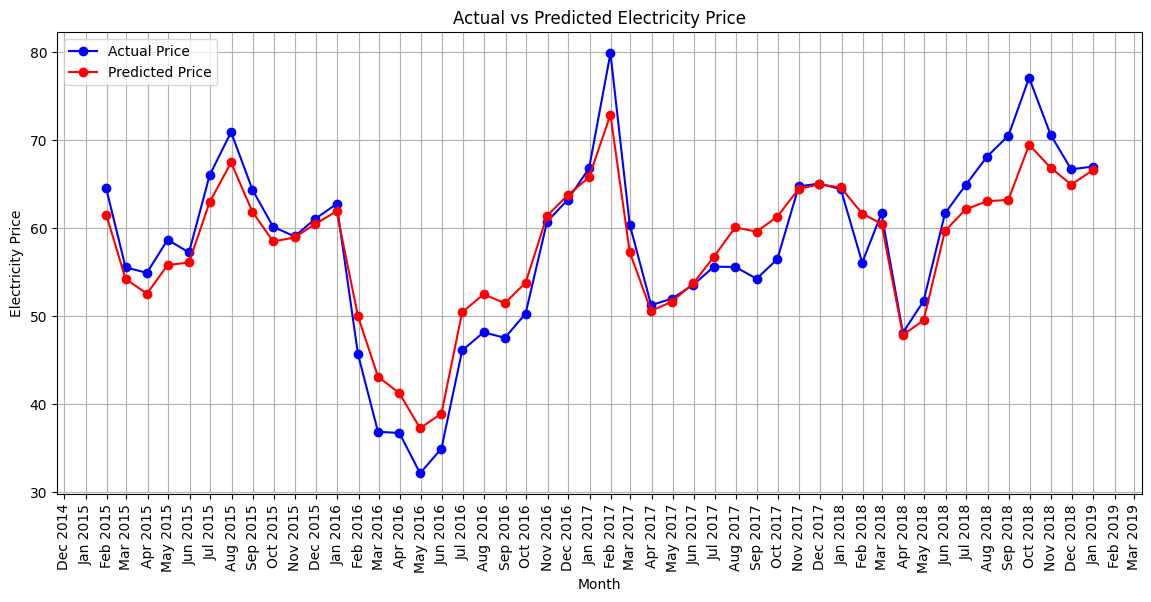

In [ ]:
#Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price (Random Forest Model with HP tuning))")

test_indices = X_test_price.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_rf_tun})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 15: Gradient Boosting Model (without parameter tuning)

For Load Prediction

In [ ]:
# Initialize the Gradient Boosting model with a random state for reproducibility
gb_model = GradientBoostingRegressor(random_state=40)

# Fit the model on the training data
gb_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_demand)

# Calculate MAPE
mape_gb = mean_absolute_percentage_error(y_test_demand, y_pred_gb)
print(f'Gradient Boosting for Load\n  MAPE : {mape_gb * 100:.2f}%')

# Calculate MAE
mae_gb = mean_absolute_error(y_test_demand, y_pred_gb)
print(f'  MAE : {mae_gb:.2f}')

# Calculate RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test_demand, y_pred_gb))
print(f'  RMSE : {rmse_gb:.2f}')

# Calculate R^2 (Coefficient of Determination)
r2_gb = r2_score(y_test_demand, y_pred_gb)
print(f'  R2 : {r2_gb:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb = adjusted_r2_score(r2_gb, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_gb:.2f}')

Gradient Boosting for Load
  MAPE : 1.06%
  MAE : 304.01
  RMSE : 455.80
  R2 : 0.99
  Adjusted R2 : 0.99


Actual vs Predicted Electricity Load (Gradient Boosting Model)


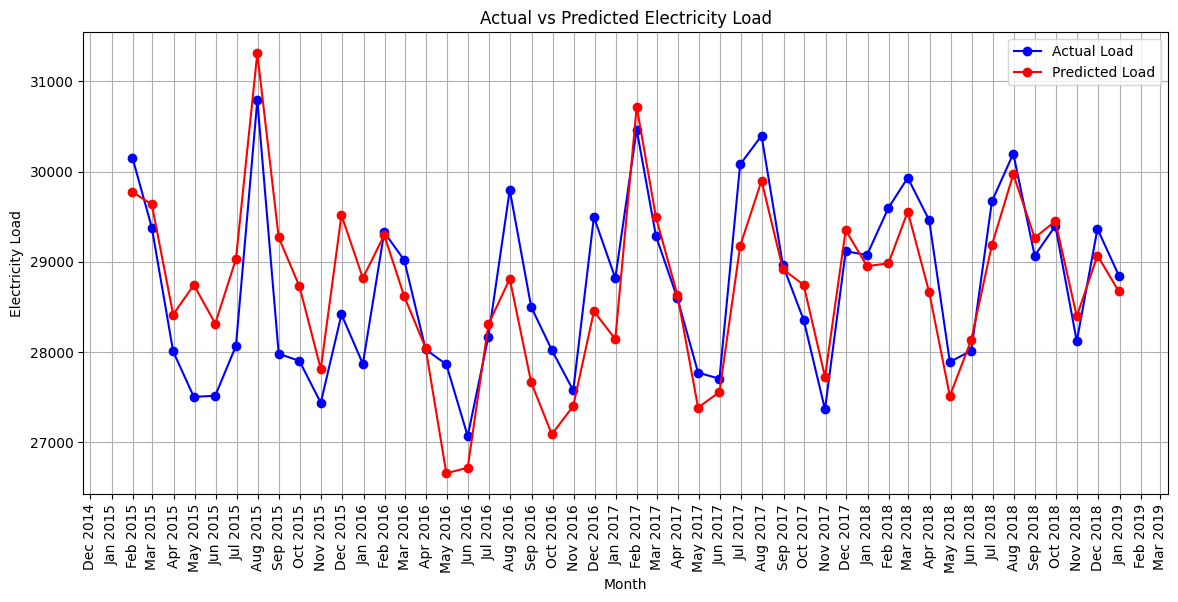

In [ ]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_demand, y_train_demand)

y_pred_gb = gb_model.predict(X_test_demand)

#Actual vs Predicted Electricity Load
print("Actual vs Predicted Electricity Load (Gradient Boosting Model)")

test_indices = X_test_demand.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_gb})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
# Initialize the Gradient Boosting model with a random state for reproducibility
gb_model = GradientBoostingRegressor(random_state=40)

# Fit the model on the training data
gb_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_price)

# Calculate MAPE
mape_gb = mean_absolute_percentage_error(y_test_price, y_pred_gb)
print(f'Gradient Boosting for Price \n  MAPE : {mape_gb * 100:.2f}%')

# Calculate MAE
mae_gb = mean_absolute_error(y_test_price, y_pred_gb)
print(f'  MAE : {mae_gb:.2f}')

# Calculate RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test_price, y_pred_gb))
print(f'  RMSE : {rmse_gb:.2f}')

# Calculate R^2 (Coefficient of Determination)
r2_gb = r2_score(y_test_price, y_pred_gb)
print(f'  R2 : {r2_gb:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb = adjusted_r2_score(r2_gb, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_gb:.2f}')

Gradient Boosting for Price 
  MAPE : 12.36%
  MAE : 6.09
  RMSE : 7.93
  R2 : 0.70
  Adjusted R2 : 0.70


Actual vs Predicted Electricity Price (Gradient Boosting Model)


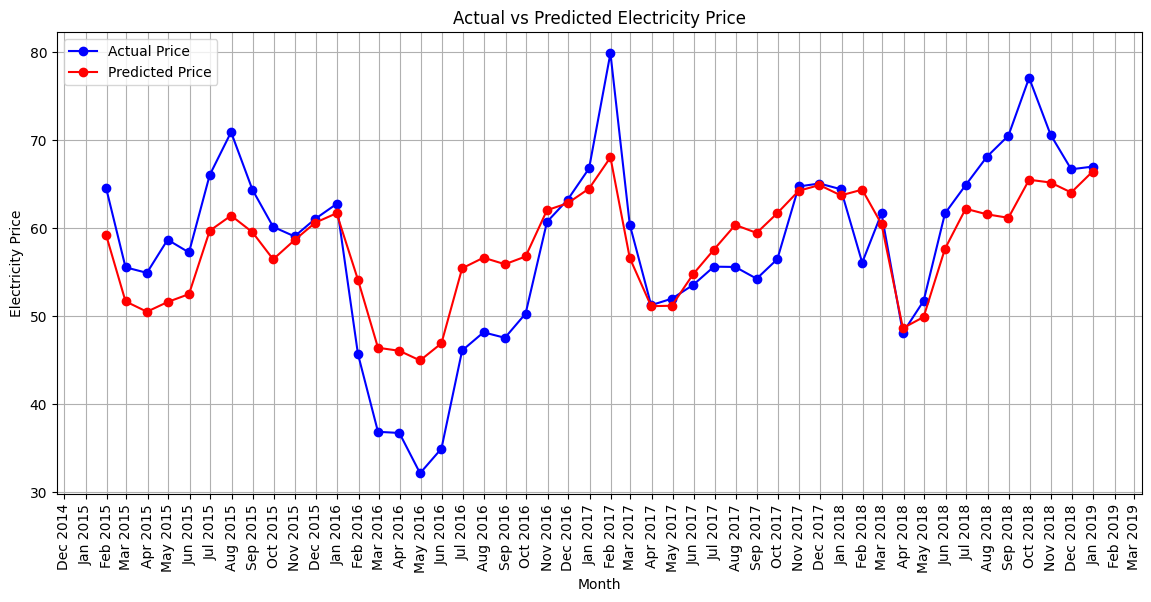

In [ ]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_price, y_train_price)

y_pred_gb = gb_model.predict(X_test_price)

#Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price (Gradient Boosting Model)")

test_indices = X_test_price.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_gb})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 16: Gradient Boosting Model (with parameter tuning)

For Load Prediction

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train_load = pd.DataFrame(np.random.rand(1000, 10), columns=[f'feature{i}' for i in range(1, 11)])
y_train_load = pd.Series(np.random.rand(1000))
X_test_load = pd.DataFrame(np.random.rand(200, 10), columns=[f'feature{i}' for i in range(1, 11)])
y_test_load = pd.Series(np.random.rand(200))

# Define the parameter grid with fewer combinations
param_grid = {
    'learning_rate': [0.01, 0.03],
    'subsample': [0.9, 0.5],
    'n_estimators': [100, 500],
    'max_depth': [4]
}

# Split the training data into a smaller subset for faster GridSearchCV
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_load, y_train_load, train_size=0.3, random_state=40)

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=40)

# Initialize GridSearchCV with fewer cross-validation folds
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_sample, y_train_sample)

# Get the best model
best_gbr_load = grid_search.best_estimator_

# Train the best model on the full training data
best_gbr_load.fit(X_train_load, y_train_load)

# Predict using the best model
y_pred_load = best_gbr_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

# Print best parameters and metrics
print(f'Gradient Boosting (Tuned) for Load \n  MAPE : {mape_rf_tuned * 100:.2f}%')
print(f'  MAE : {mae_rf_tuned:.2f}')
print(f'  RMSE : {rmse_rf_tuned:.2f}')
print(f'  R2 : {r2_rf_tuned:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf_tuned:.2f}')

# Print best parameters and score
best_estimator = grid_search.best_estimator_
best_score = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"\nAcross all searched parameters")
print(f"  The best estimator: {best_estimator}")
print(f"  The best score: {best_score:.4f}")
print(f"  The best parameters: {best_params}")

Gradient Boosting (Tuned) for Load
  MAPE : 1.28%
  MAE : 350.74
  RMSE : 500.20
  R2 : 0.99
  Adjusted R2 : 0.99

Across all searched parameters
  The best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=4, random_state=40, subsample=0.5)
  The best score: 0.0443
  The best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.5}


Actual vs Predicted Electricity Demand (Gradient Boosting Model with HP tuning)
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   2.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1,

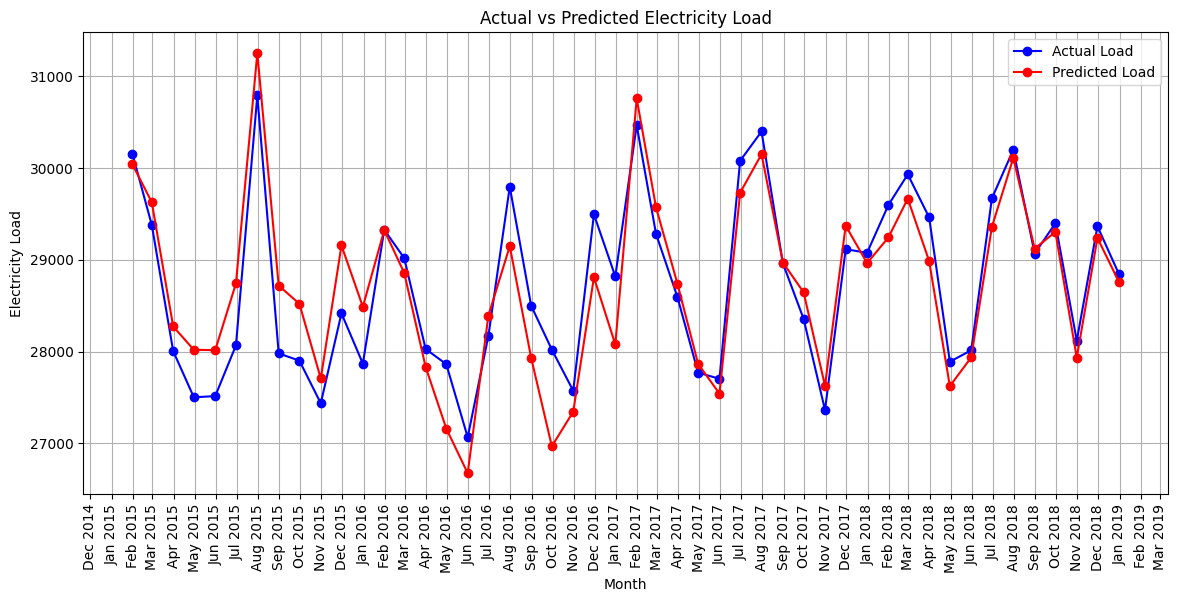

In [ ]:
#Actual vs Predicted Electricity Demand
print("Actual vs Predicted Electricity Demand (Gradient Boosting Model with HP tuning)")

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=40)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

grid_search_gb.fit(X_train_demand, y_train_demand.ravel())

best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_tun = best_gb_model.predict(X_test_demand)
test_indices = X_test_demand.index

test_dates = merged_df.loc[test_indices, 'time']
test_dates = pd.to_datetime(test_dates)

results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_gb_tun})
results_df.set_index('Date', inplace=True)

monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6]
}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=40)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions,
                                   n_iter=50, scoring='neg_mean_absolute_percentage_error', cv=3,
                                   random_state=40, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV
random_search.fit(X_train_price, y_train_price)

# Get the best model
best_gbr = random_search.best_estimator_

# Predict using the best model
y_pred_price = best_gbr.predict(X_test_price)

# Evaluation metrics
mape_price = mean_absolute_percentage_error(y_test_price, y_pred_price)
mae_price = mean_absolute_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2_price = r2_score(y_test_price, y_pred_price)
adjusted_r2_price = 1 - (1 - r2_price) * (X_test_price.shape[0] - 1) / (X_test_price.shape[0] - X_test_price.shape[1] - 1)

# Print metrics
print(f'Gradient Boosting (Tuned) for Price')
print(f'  MAPE : {mape_price * 100:.2f}%')
print(f'  MAE : {mae_price:.2f}')
print(f'  RMSE : {rmse_price:.2f}')
print(f'  R2 : {r2_price:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_price:.2f}')

# Print best parameters and score
print(f"\nBest parameters found:")
print(random_search.best_params_)
print(f"Best MAE score: {random_search.best_score_}")

Gradient Boosting (Tuned) for Price
  MAPE : 7.76%
  MAE : 0.8632483105083985
  RMSE : 5.27
  R2 : 0.87
  Adjusted R2 : 0.87

Best parameters found:
{'learning_rate': 0.15, 'n_estimators': 250}
Best MAE score: 0.8632483105083985


Actual vs Predicted Electricity Price (Gradient Boosting with HP tuning))


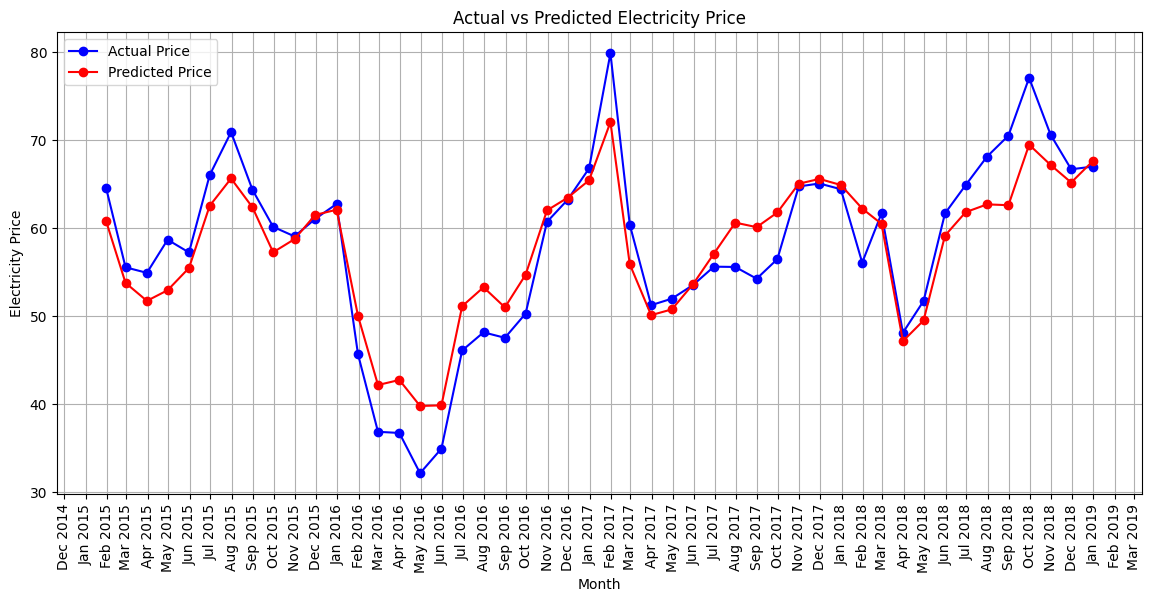

In [ ]:
#Actual vs Predicted Electricity Price

best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_tun = best_gb_model.predict(X_test_price)
print("Actual vs Predicted Electricity Price (Gradient Boosting with HP tuning))")

test_indices = X_test_price.index
test_dates = merged_df.loc[test_indices, 'time']

test_dates = pd.to_datetime(test_dates)
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_gb_tun})

results_df.set_index('Date', inplace=True)
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

# Step 17: RNN - Long short Term Memory (LSTM) Model

For Load Prediction

In [ ]:
# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_demand)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_demand.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=40)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             14400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34651 (135.36 KB)
Trainable params: 34651 (135.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
614/614 [==============================] - 10s 9ms/step - loss: 0.4342 - val_loss: 0.2973
Epoch 2/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2882 - val_loss: 0.2716
Epoch 3/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2699 - val_loss: 0.2633
Epoch 4/50
614/614 [==============================] - 4s 6ms/step - loss: 0.2605 - val_loss: 0.2541
Epoch 5/50
614/614 [==============================] - 4s 7ms/step - loss: 0.2532 - val_loss: 0.2493
Epoch 6/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2460 - val_loss: 0.2453
Epoch 7/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2417 - val_loss: 0.2393
Epoch 8/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2374 - val_loss: 0.2367
Epoch 9/50
614/614 [==============================] - 5s 8ms/step - loss: 0.2323 - val_loss: 0.2336
Epoch 10/50
614/614 [==============================] - 3s 5ms/step - loss: 0.2288 - val_loss: 0.231

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate the errors
mape_LSTM = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM for Load \n  MAPE : {mape_LSTM * 100:.2f}%')

mae_LSTM = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'  MAE : {mae_LSTM:.2f}')

rmse_LSTM = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'  RMSE : {rmse_LSTM:.2f}')

r2_LSTM = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'  R2 : {r2_LSTM:.2f}')

def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM = adjusted_r2_score(r2_LSTM, X_train.shape[0], X_train.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_LSTM:.2f}')


329/329 [==============================] - 2s 3ms/step
LSTM for Load 
  MAPE : 0.99%
  MAE : 279.00
  RMSE : 411.18
  R2 : 0.99
  Adjusted R2 : 0.99


329/329 [==============================] - 1s 2ms/step
Actual vs Predicted Electricity Load (LSTM Model)


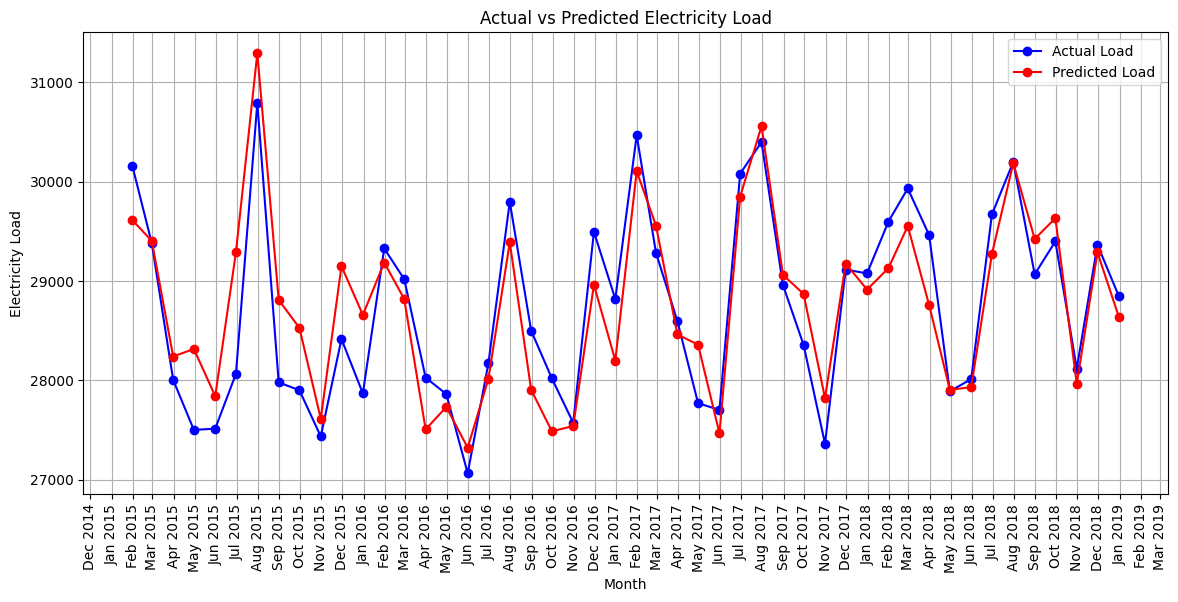

In [ ]:
#Actual vs Predicted Electricity Load
print("Actual vs Predicted Electricity Load (LSTM Model)")
test_indices = X_test_demand.index

test_dates = merged_df.loc[test_indices, 'time']
test_dates = pd.to_datetime(test_dates)

y_test_rescaled = y_test_rescaled.ravel()
y_pred_rescaled = y_pred_rescaled.ravel()

results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})
results_df.set_index('Date', inplace=True)

monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

For Price Prediction

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_price)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_price.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=40)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             19800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 40051 (156.45 KB)
Trainable params: 40051 (156.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
614/614 [==============================] - 9s 8ms/step - loss: 0.3854 - val_loss: 0.2630
Epoch 2/50
614/614 [==============================] - 5s 8ms/step - loss: 0.2233 - val_loss: 0.2064
Epoch 3/50
614/614 [==============================] - 3s 5ms/step - loss: 0.1817 - val_loss: 0.1787
Epoch 4/50
614/614 [==============================] - 4s 6ms/step - loss: 0.1591 - val_loss: 0.1683
Epoch 5/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1439 - val_loss: 0.1549
Epoch 6/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1332 - val_loss: 0.1489
Epoch 7/50
614/614 [==============================] - 3s 6ms/step - loss: 0.1233 - val_loss: 0.1395
Epoch 8/50
614/614 [==============================] - 4s 6ms/step - loss: 0.1171 - val_loss: 0.1341
Epoch 9/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1099 - val_loss: 0.1274
Epoch 10/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1048 - val_loss: 0.1202

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate the errors
mape_LSTM = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM for Price \n  MAPE : {mape_LSTM * 100:.2f}%')

mae_LSTM = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'  MAE : {mae_LSTM:.2f}')

rmse_LSTM = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'  RMSE : {rmse_LSTM:.2f}')

r2_LSTM = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'  R2 : {r2_LSTM:.2f}')

def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM = adjusted_r2_score(r2_LSTM, X_test.shape[0], X_test.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_LSTM:.2f}')


329/329 [==============================] - 1s 2ms/step
LSTM for Price 
  MAPE : 5.74%
  MAE : 2.95
  RMSE : 3.96
  R2 : 0.92
  Adjusted R2 : 0.92


Actual vs Predicted Electricity Price (LSTM Model)


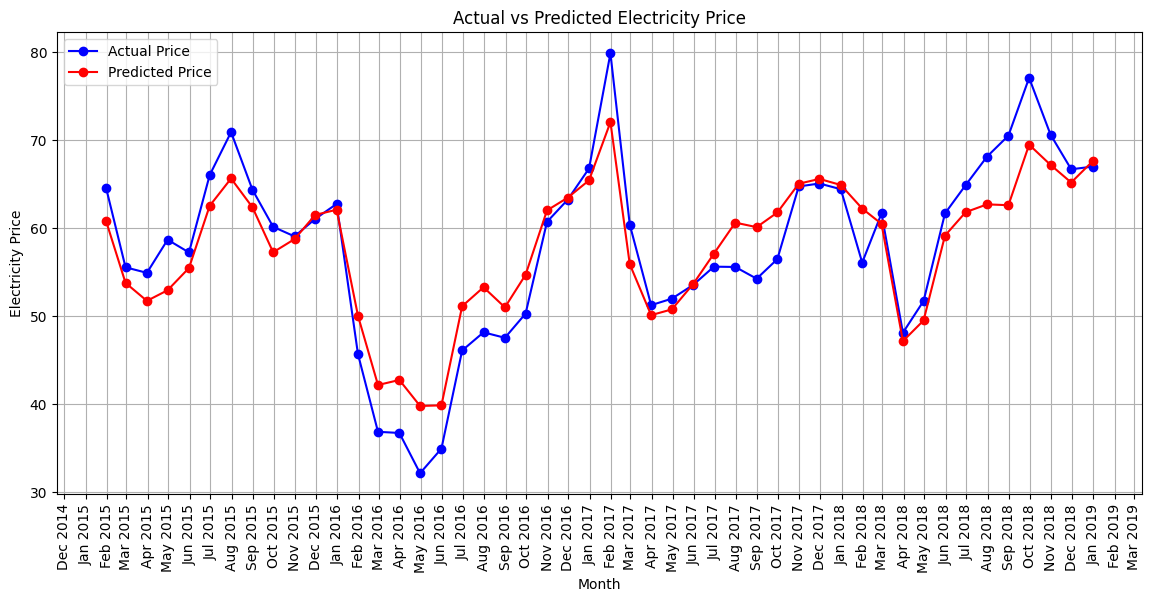

In [ ]:
# Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price (LSTM Model)")

# Assuming test_indices, test_dates, y_test_rescaled, and y_pred_rescaled are available for price data
test_indices_price = X_test_price.index

test_dates_price = merged_df.loc[test_indices_price, 'time']
test_dates_price = pd.to_datetime(test_dates_price)

# Flatten the arrays
y_test_rescaled_price = y_test_price.ravel()
y_pred_rescaled_price = y_pred_gb_tun.ravel()

# Create a DataFrame for results
results_df_price = pd.DataFrame({'Date': test_dates_price, 'Actual': y_test_rescaled_price, 'Predicted': y_pred_rescaled_price})
results_df_price.set_index('Date', inplace=True)

# Resample to monthly means
monthly_results_price = results_df_price.resample('M').mean()

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_price.index, monthly_results_price['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_price.index, monthly_results_price['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# Step 18: Final Report

In [ ]:
# Create Tables for Load and Price Models
from tabulate import tabulate

# Data for Load Forecasting
data_load = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAPE (%)': [1.10, 1.45, 1.07, 1.05, 1.06, 1.28, 0.99],
    'MAE': [314.41, 417.40, 305.21, 299.79, 304.01, 350.74, 279.00],
    'RMSE': [474.47, 606.89, 455.86, 454.39, 455.80, 500.20, 411.18],
    'R2': [0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99],
    'Adjusted R2': [0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99]
}

# Data for Price Forecasting
data_price = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAPE (%)': [15.76, 9.26, 6.92, 11.06, 12.36, 7.76, 5.74],
    'MAE': [7.73, 4.68, 3.41, 5.53, 4.37, 0.86, 2.95],
    'RMSE': [9.86, 7.42, 4.90, 7.45, 7.93, 5.27, 3.96],
    'R2': [0.53, 0.73, 0.88, 0.73, 0.70, 0.87, 0.92],
    'Adjusted R2': [0.53, 0.73, 0.88, 0.86, 0.70, 0.87, 0.92]
}

# Create DataFrames and round values to 2 decimals
df_load = pd.DataFrame(data_load).round(2)
df_price = pd.DataFrame(data_price).round(2)

# Print title and DataFrame for Load Forecasting
text = "\nFor Load Forecasting\n"
underline = "_" * len(text)

print(text)
print(tabulate(df_load, headers='keys', tablefmt='fancy_grid', showindex=False))

# Print title and DataFrame for Price Forecasting
text_2 = "\n\nFor Price Forecasting\n"
underline_2 = "_" * len(text_2)

print(text_2)
print(tabulate(df_price, headers='keys', tablefmt='fancy_grid', showindex=False))


For Load Forecasting

╒═══════════════════════════╤════════════╤════════╤════════╤══════╤═══════════════╕
│ MODEL                     │   MAPE (%) │    MAE │   RMSE │   R2 │   Adjusted R2 │
╞═══════════════════════════╪════════════╪════════╪════════╪══════╪═══════════════╡
│ Linear Regression         │       1.1  │ 314.41 │ 474.47 │ 0.99 │          0.99 │
├───────────────────────────┼────────────┼────────┼────────┼──────┼───────────────┤
│ Decision Tree             │       1.45 │ 417.4  │ 606.89 │ 0.98 │          0.98 │
├───────────────────────────┼────────────┼────────┼────────┼──────┼───────────────┤
│ Random Forest             │       1.07 │ 305.21 │ 455.86 │ 0.99 │          0.99 │
├───────────────────────────┼────────────┼────────┼────────┼──────┼───────────────┤
│ Random Forest (Tuned)     │       1.05 │ 299.79 │ 454.39 │ 0.99 │          0.99 │
├───────────────────────────┼────────────┼────────┼────────┼──────┼───────────────┤
│ Gradient Boosting         │       1.06 │ 304.01 │ 4

Based on the metrics obtained:

- **Load Forecasting:** LSTM shows comparatively the lowest errors (MAPE, MAE, RMSE) and highest goodness-of-fit (R2, Adjusted R2) among all models.

- **Price Forecasting:** Similarly, LSTM demonstrates the lowest errors and competitive goodness-of-fit metrics compared to other models.

**Conclusion:** LSTM emerges as the preferred model for both load and price forecasting, delivering superior predictive accuracy and reliability across various evaluation criteria.

**Important Variables**

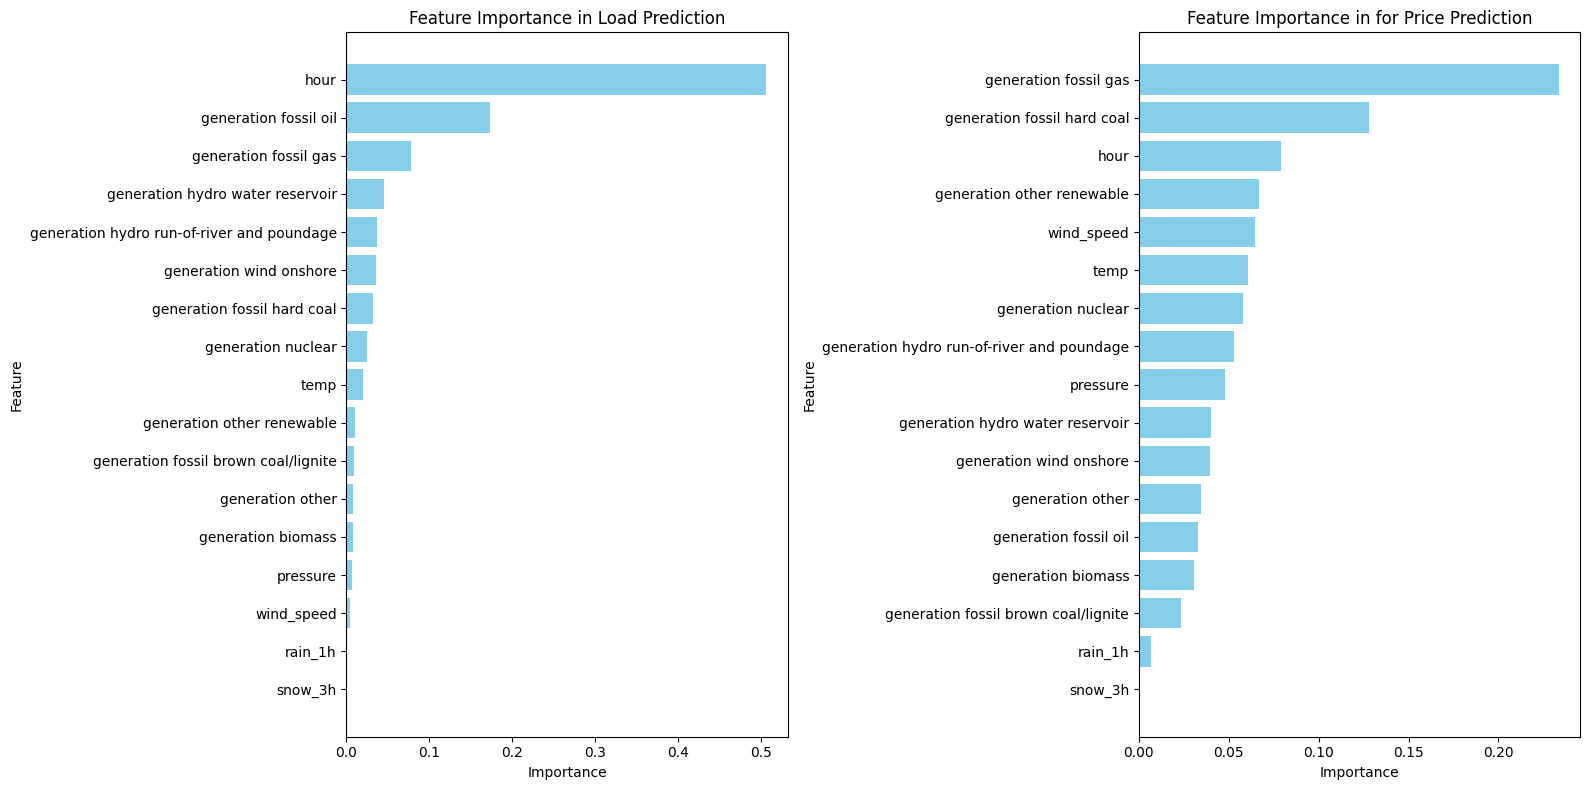

In [ ]:
# Define variables of interest
load_variables = [
    'generation fossil gas', 'generation fossil hard coal',
    'generation other renewable', 'hour', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation nuclear', 'wind_speed', 'pressure', 'generation other', 'temp',
    'generation fossil oil', 'generation biomass', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'rain_1h', 'snow_3h' ]
price_variables = [
    'generation fossil gas', 'generation fossil hard coal',
    'generation other renewable', 'hour', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation nuclear', 'wind_speed', 'pressure', 'generation other', 'temp',
    'generation fossil oil', 'generation biomass', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'rain_1h', 'snow_3h' ]

rf_load = RandomForestRegressor(n_estimators=100, random_state=40)
rf_load.fit(merged_df[load_variables], merged_df['total load actual'])

rf_price = RandomForestRegressor(n_estimators=100, random_state=40)
rf_price.fit(merged_df[price_variables], merged_df['price actual'])

# Plotting Feature Importance for Load Prediction and Price Prediction side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance for load prediction
importance_load = rf_load.feature_importances_
importance_df_load = pd.DataFrame({'Feature': load_variables, 'Importance': importance_load})
importance_df_load = importance_df_load.sort_values(by='Importance', ascending=False)
axes[0].barh(importance_df_load['Feature'], importance_df_load['Importance'], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Importance in Load Prediction')
axes[0].invert_yaxis()

# Feature importance for price prediction
importance_price = rf_price.feature_importances_
importance_df_price = pd.DataFrame({'Feature': price_variables, 'Importance': importance_price})
importance_df_price = importance_df_price.sort_values(by='Importance', ascending=False)
axes[1].barh(importance_df_price['Feature'], importance_df_price['Importance'], color='skyblue')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')
axes[1].set_title('Feature Importance in for Price Prediction')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

***Best Features for Load Forecasting:***

- **Actual Load Features:** total load actual, peak/off-peak load
- **Generation Sources:** generation hydro pumped storage consumption, generation fossil gas, generation fossil oil, generation biomass, generation hydro water reservoir, generation fossil hard coal/lignite, generation other renewable, generation solar, generation wind onshore, generation nuclear
- **Price-Related Features:** forecast solar day ahead, avg_hourly_price, price_actual_interpolated, price actual, price day ahead
- **Weather and Environmental Factors:** temp_max, temp, wind_deg, wind_speed, humidity, pressure, weather_icon, weather_id
- **Temporal and Seasonal Factors:** hour, is_weekend, season_Winter

***Best Features for Price Forecasting:***

- **Price-Related and Load Features:** price_actual_interpolated, total load forecast, total load actual, avg_hourly_demand
- **Generation Sources:** generation fossil hard coal, generation fossil gas, generation biomass, generation fossil oil, generation other renewable, generation waste, generation fossil brown coal/lignite
- **Temporal and Seasonal Factors:** hour, is_weekend, Thursday (Thur), peak/off-peak, seasonal indicators (Spring, Autumn)
- **Monthly Factors:** March (Mar), December (Dec), November (Nov), October (Oct)
- **Weather Factors:** pressure, temp

These feature sets are tailored to optimize the accuracy and robustness of load and price forecasting models, encompassing a comprehensive range of relevant factors from energy generation and consumption to weather conditions and temporal patterns.

**Monthly Actual vs Predicted Electricity Demand**

Actual vs Predicted Electricity Demand


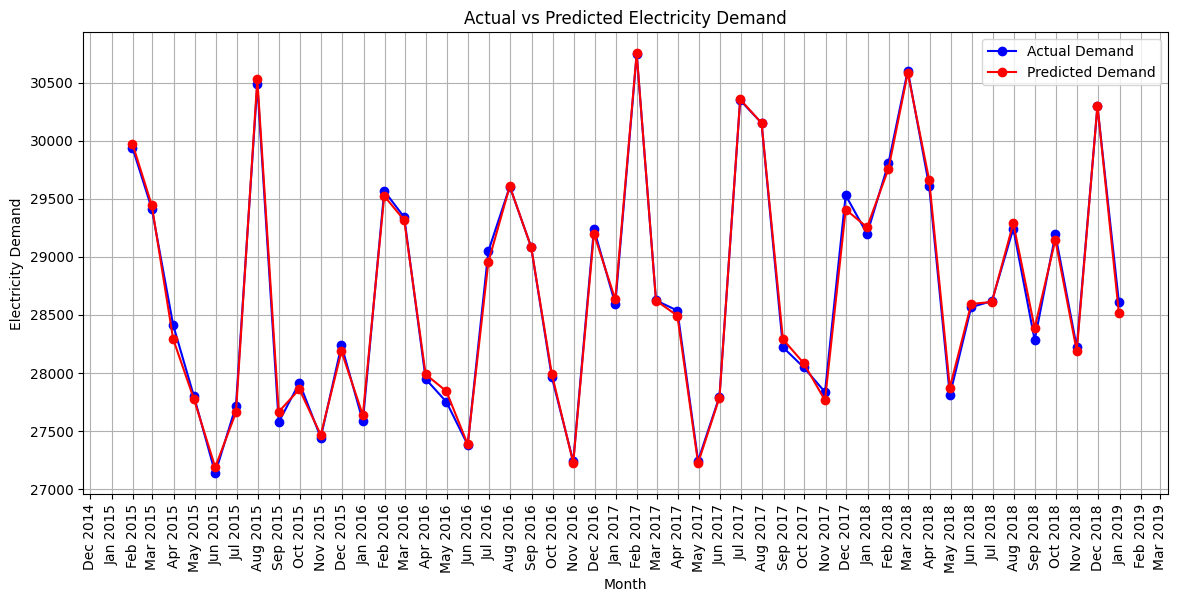

In [ ]:
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.2, random_state=42)

rf_model.fit(X_train_demand, y_train_demand)

# Actual vs Predicted Electricity Demand
print("Actual vs Predicted Electricity Demand")
y_pred_rf = rf_model.predict(X_test_demand)

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_rf})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

**Monthly Actual vs Predicted Electricity Price**

Actual vs Predicted Electricity Price


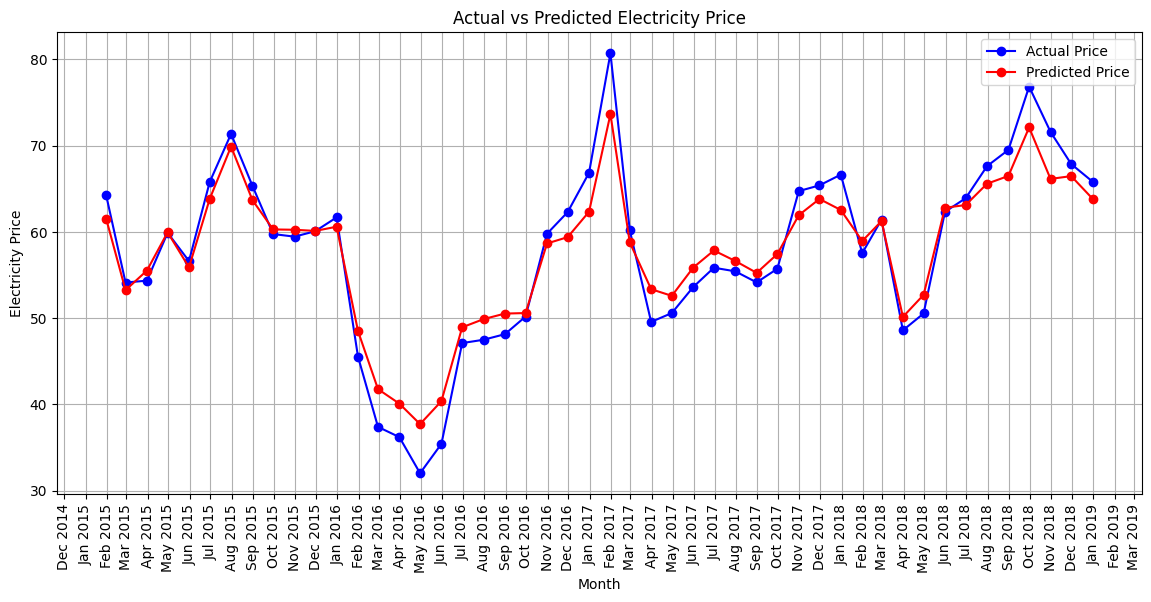

In [ ]:
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.2, random_state=42)

rf_model.fit(X_train_price, y_train_price)

# Actual vs Predicted Electricity Price
print("Actual vs Predicted Electricity Price")
y_pred_rf_price = rf_model.predict(X_test_price)

test_indices_price = X_test_price.index

# Get the corresponding dates for the test set
test_dates_price = merged_df.loc[test_indices_price, 'time']

# Convert test_dates to datetime if not already
test_dates_price = pd.to_datetime(test_dates_price)

# Create a DataFrame with the dates, actual, and predicted values
results_df_price = pd.DataFrame({'Date': test_dates_price, 'Actual': y_test_price, 'Predicted': y_pred_rf_price})

# Set Date as the index
results_df_price.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_price = results_df_price.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_results_price.index, monthly_results_price['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_price.index, monthly_results_price['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()

**Selected Model for Load Forecasting: LSTM**

**Selected Model for Price Forecasting: LSTM**